# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple.

Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage
import math

### Parameters

In [2]:
M=10**3 #number of particles
n_pred=715  #number of predictions
N_daytype=8  #number of day types

### Load temperatures data 2015-2016

In [3]:
df_temp=pd.read_csv('data/temp_1516.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,hour,t
0,2015-01-01,00:00,5.057414
1,2015-01-01,03:00,4.609138
2,2015-01-01,06:00,4.729828
3,2015-01-01,09:00,6.052241
4,2015-01-01,12:00,9.347069


In [4]:
#temperatures every day at 3pm
temp_day=df_temp[df_temp.hour=="15:00"]
temp_day.head()
#Array vector of temperatures for each day of the year
T_h=list(temp_day.t)

### Load electricity data

In [5]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df=df.drop(["daytype"+str(i) for i in range(0,9)],axis=1)
df=df.drop(df.columns[0],axis=1)
df.index=range(0,len(df))
df=df.sort_values(by=['Date'])
df['Date - Heure']=pd.to_datetime(df['Date - Heure'])
df.sort_values(by=["Date - Heure"])
#truncate to the data from 2015
df=df[(df.Date >='2015-01-01')]
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype
166957,2015-01-01 03:30:00,2015-01-01,04:30,64838,DÃ©finitive,6
153294,2015-01-01 18:30:00,2015-01-01,19:30,72562,DÃ©finitive,6
153293,2015-01-01 18:00:00,2015-01-01,19:00,71766,DÃ©finitive,6
152017,2015-01-01 01:00:00,2015-01-01,02:00,71134,DÃ©finitive,6
152018,2015-01-01 04:30:00,2015-01-01,05:30,64379,DÃ©finitive,6


### Set variables of electricity demand

In [6]:
from datetime import date
df['Consommation']=df['Consommation (MW)']   #leave it in MW
#For prediction, every day at 3pm
consumption_day_ahead = list(df[df['Heure']=='15:00']['Consommation'])
#for initialization
consumption = list(df[df['Heure']=='15:00']['Consommation'][:30])

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option A: Set values by hand

### Option C: MCMC using MHA or Gibbs (TBA)

#### Freeze parameters from Zak's simulation in gibbs-parameters_init_v1

In [7]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
len_init=15
pred_forward=[0,1]

In [8]:
#Load pickle file
import pickle
output_file ='data/parameters_init_20180113-135329.pkl'
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init["x_init"][:20]

array([  6.27772271e+20,   7.74432522e+04,   7.18859618e+04,
         6.49227561e+04,   6.66906797e+04,   6.45463399e+04,
         7.44844711e+04,   7.35432483e+04,   7.28854527e+04,
         7.64918960e+04,   6.16447396e+04,   6.96833028e+04,
         6.56803045e+04,   6.42648669e+04,   6.05432962e+04,
         5.99115354e+04,   6.06208026e+04,   7.04703987e+04,
         7.03640065e+04,   7.41647499e+04])

In [9]:
parameters_init

{'g_heat_init': array([-814623.94530988,   -1103.5042025 ,  -13509.35223552,
         -12839.18874712,  -13810.69394068,  -13621.95767042,
         -16305.45122647,  -16251.90232773,  -16229.3696953 ,
         -17229.49394215,  -13669.17597616,  -15726.25635544,
         -14808.97478176,  -14519.69267177,  -13655.86349596,
         -13546.63330023,  -13762.6351832 ,  -16223.92473751,
         -16231.78960435,  -17198.22294889,  -16084.04185055,
         -14859.33888566,  -15086.97652322,  -15659.32736924,
         -15025.21396291,  -16876.95500528,  -18016.91503558,
         -14386.93382501,  -14456.1228341 ,  -17258.13559834,
         -16399.27181928,  -14184.38234493,  -17037.65684651,
         -17577.66776037,  -15905.47860891,  -14955.89959227,
         -16811.49451007,  -15179.88058645,  -16273.87576028,
         -16666.00910714,  -16425.26301396,  -17107.27359641,
         -17374.00623292,  -13665.90412278,  -16588.1106145 ,
         -16457.00065552,  -16112.43401709,  -15547.969

In [10]:
s_init=parameters_init['s_init']
g_heat_init=parameters_init['g_heat_init']
sigma_s_init=parameters_init['sigma_s_init']
sigma_g_init=parameters_init['sigma_g_init']
x_init=parameters_init['x_init']
sigma2=parameters_init['sigma2']
u_h=parameters_init['u_h']
kappa=parameters_init['kappa']
w_init=parameters_init['w_init']

In [11]:
sigma2=np.ones(M)*3*10**7
sigma_g_init=np.ones(M)*10**4
sigma_s_init=np.ones(M)*10**4
kappa=np.ones(M)

In [12]:
w_init[0]=np.median(w_init)
x_init[0]=np.median(x_init)
g_heat_init[0]=np.median(g_heat_init)
s_init[0]=np.median(s_init)

### Part 2: regularize weights and x if necessary

In [13]:
#STEP 2 OF PARTICLE FILTER
def resample(x_pred,w_prev,nbdays_pred_today,len_init,n,sigma_s,sigma_g,g_h,s,sigma,ESS):   
    #compute y_n
    delta_cons_gaus=-np.square(consumption_day_ahead[len_init+n+nbdays_pred_today]-x_pred)/(2*sigma**2)
    y_n=np.exp(delta_cons_gaus)
    #compute new weights
    if n>0:
        w_=w_prev*y_n
    else:
        w_=w_prev
    #likelihood of y_n
    lh_y_n=np.sum(delta_cons_gaus)
    #normalize weights
    w_h=w_/sum(w_)
    #calculate ESS
    ESS=1/sum(np.square(w_h))
    x =np.zeros(M)
    w =np.zeros(M)
    print("ESS of normalized weights=",round(ESS,6))
    if ESS <0.001*M: #reset the weights, keep x predicted as such
        print("ESS <0.001*M")
        x=x_pred
        if n==0:
            w=np.ones(M)*(1/M)
        w=w_prev
    elif (ESS>=0.001*M and ESS<0.5*M):  #reset all the weights, add some noise to a fraction of the x's
        print("ESS>=0.001*M and ESS_0<0.5*M")
        x,w,sigma_s,sigma_g,g_h,s=resample_multinomial(x_pred,w_h,sigma_s,sigma_g,g_h,s)
    elif ESS>=0.5*M:  #No degeneracy
        print("ESS>=0.5*M")
        x=x_pred
        w=w_h
    else:
        print("ESS critically low")
        x=x_pred
        if n==0:
            w=np.ones(M)*(1/M)
        w=w_prev
            
    print("new ESS=",round(1/sum(np.square(w)),6))
    return x,w,ESS,lh_y_n,sigma_s,sigma_g,g_h,s,w_h

In [14]:
def resample_multinomial(x_temp,w_temp,sigma_s,sigma_g,g_h,s):
    multinomial = np.random.multinomial(1,w_temp,M)
    new_x = np.zeros(M)
    new_s = np.zeros(M)
    new_g_heat = np.zeros(M)
    new_sigma_s = np.zeros(M)
    new_sigma_g = np.zeros(M)
    for i in range(M):
        new_x[i]=x_temp[np.argmax(multinomial[i,])]
        new_s[i]=s[np.argmax(multinomial[i,])]
        new_g_heat[i]=g_h[np.argmax(multinomial[i,])]
        new_sigma_s[i]=sigma_s[np.argmax(multinomial[i,])]
        new_sigma_g[i]=sigma_g[np.argmax(multinomial[i,])]
    new_w=(1/M)*np.ones(M)   
    return new_x,new_w,new_sigma_s,new_sigma_g,new_g_heat,new_s

In [15]:
#initialize matrix of x_heat, x_season
ESS=np.array(np.ones(n_pred+1))
x =np.zeros([n_pred+1,M])
w =np.zeros([n_pred+1,M])
lh_y_n =np.zeros(n_pred+1)
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])
entrop=np.zeros([len(pred_forward),n_pred])

x[0,:],w[0,:],ESS[0],lh_y,sigma_s_init,sigma_g_init,g_heat_init,s_init,entrop=resample(x_init,w_init,2,15,0,sigma_s_init,
                                                                                sigma_g_init,
                                                                                g_heat_init,s_init,sigma2**0.5,ESS)

ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

In [16]:
def x_season(day_type,k_day,s_prev,sigma_s_prev):
    nu=truncnorm.rvs(a = (-sigma_s_prev-0) / sigma_g_init , b = np.inf, loc= 0, scale = sigma_g_init, size=M)
    sigma_s=sigma_s_prev+nu
    err=truncnorm.rvs(a = -s_prev / sigma_s , b = np.inf, loc= 0, scale = sigma_s, size=M)
    s=s_prev+err
    x_s=s*k_day[day_type]
    return x_s, s, sigma_s

def x_heat(g_h_prev,day,sigma_g_prev):
    nu=truncnorm.rvs(a = -sigma_g_prev / sigma_g_init , b = np.inf, loc= 0, scale = sigma_g_init, size=M)
    sigma_g=sigma_g_prev+nu
    err=truncnorm.rvs(a = -np.inf , b =(-g_h_prev-0) / sigma_g, loc= 0, scale = sigma_g, size=M)
    g_h=g_h_prev+err
    if(u_h-T_h[day]<0):
        print("No heating effect")
    x_h=g_h*(T_h[day]-u_h)*max(np.sign(u_h-T_h[day]),0)
    return x_h, g_h, sigma_g

In [17]:
daytype=np.array(df.daytype)

In [18]:
#Initialize parameters
def particle_filter(nbdays_pred_today,len_init,len_filtering,s,g_h,sigma_s,sigma_g,sigma,lh_y):
    lh_y_n=np.zeros(len_filtering)
    x_pred=np.zeros([len_filtering,M])
    x_pred_mean=np.zeros(len_filtering)
    ESS=np.zeros(len_filtering)
    w_h=np.zeros([len_filtering,M])
    entrop_n=np.zeros([10,len_filtering])
    for n in range(1,len_filtering):
        print("n=",n)
        #prediction X[n] one day ahead, hourly forecast
        x_s=x_season(int(daytype[len_init+n+nbdays_pred_today]),kappa,s,sigma_s)
        x_h=x_heat(g_h,n+len_init+nbdays_pred_today,sigma_g)
        x_pred[n,:]=x_s[0]+x_h[0]
        x_pred_mean[n]=np.mean(x_pred[n,:])
        print("x_pred_mean =","{:.2e}".format(np.mean(x_pred[n,:])),
              "real consumption=","{:.2e}".format(consumption_day_ahead[n]))
        print("x_pred min=","{:.2e}".format(np.min(x_pred[n,:])),"x_pred max","{:.2e}".format(np.max(x_pred[n,:])))
        #take new values of parameters to feed x_season and x_heat in the next step
        s, sigma_s=x_s[1:]
        g_h, sigma_g=x_h[1:]
        #regularization
        x_pred[n,:],w[n,:],ESS[n],lh_y_n[n],sigma_s,sigma_g,g_h,s,w_h[n,:]=resample(x_pred[n,:],w[n-1,:],nbdays_pred_today,len_init,n,sigma_s,sigma_g,g_h,s,sigma,ESS)
        entrop_n[nbdays_pred_today,n-1]=-sum(w_h[n,:]*np.log(w_h[n,:]))
        print(entrop_n[nbdays_pred_today,n-1])
        print("likelihood:",lh_y_n[n])
        print("------------------------")
    return lh_y_n,x_pred_mean,ESS,entrop_n

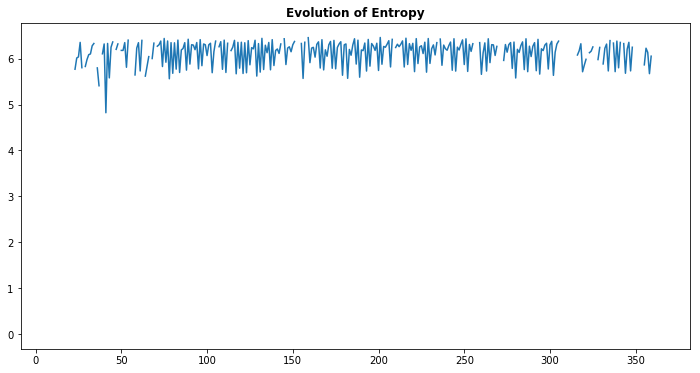

In [43]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(0,n_pred),entrop[0,:n_pred])
plt.title("Evolution of Entropy",fontweight='bold')
plt.show()

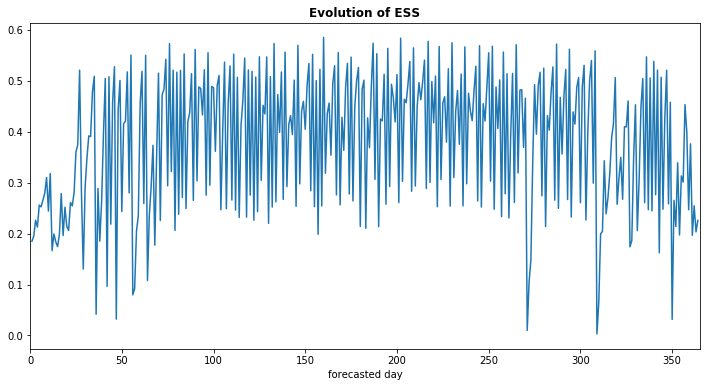

In [49]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(1,n_pred),ESS_calc[0,1:n_pred]/M)
#plt.plot(range(1,n_pred),ESS_calc[1,1:n_pred]/M)
#plt.plot(range(1,n_pred),ESS_calc[2,1:n_pred]/M)

plt.title("Evolution of ESS",fontweight='bold')
plt.xlabel('forecasted day')
plt.xlim(0,n_pred)
plt.show()

In [ ]:
fig=plt.figure(figsize=(12,6))


In [57]:
#MAPE
mape_one_day_forecast=abs((x_predict[0,:]-consumption_day_ahead[:n_pred])/consumption_day_ahead[:n_pred])
mape_value = (1/(n_pred-pred_forward[0]))*sum(mape_one_day_forecast) 
print(mape_value)

0.221995529785


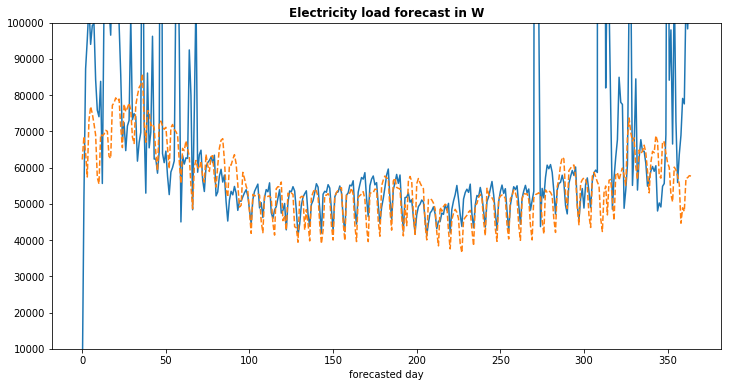

In [23]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(n_pred),x_predict[0,:])
#plt.plot(range(n_pred),x_predict[1,:])
#plt.plot(range(n_pred),x_predict[2,:])
plt.plot(range(n_pred),consumption_day_ahead[:n_pred],linestyle='--')
plt.xlabel('forecasted day')
plt.ylim(10**4,10**5)
plt.title("Electricity load forecast in W",fontweight='bold')
plt.show()

Goal: re-estimate the one-dimensional parameters ($\sigma_g,\sigma_s,\mu_h,\kappa,\sigma$)<br>
Proposal distribution for these parameters: truncated gaussian random walk<br>
We set kappa constant at 1/8



## PMMH

#### Initialization of parameters

In [19]:
u_h_current=13
sigma_current=10**4
sigma_g_current=10**4
sigma_s_current=10**4

In [20]:
len_filter_pmmh=715
len_iter_mha=200
accept_log_proba=np.zeros(len_filter_pmmh)
accept_rate=0
log_lh_init=np.zeros(len_filter_pmmh)
lh_y_prop=np.zeros(len_filter_pmmh)

In [21]:
#store the accepted value in lists
u_h_list=[]
sigma_list=[]
sigma_g_list=[]
sigma_s_list=[]

#### Initialization of hyperparameters

In [22]:
#standard deviation of normal/trunc normal proposals on parameters
std_hyp_sigma_g,std_hyp_sigma_s,std_hyp_sigma=np.ones(3)*5*10**3
std_hyp_u=1

In [23]:
#joint prior density of parameters
def log_joint_prior(u_h,sigma,sigma_g,sigma_s):
    res=0
    res=(-(u_h-14)**2)/2
    res=res+(-0.01-1)*np.log(sigma**2) - (0.01/sigma**2)
    res=res+(-0.01-1)*np.log(sigma_g**2) - (0.01/sigma_g**2)
    res=res+(-0.01-1)*np.log(sigma_s**2) - (0.01/sigma_s**2)
    return res

In [24]:
#joint log prior density initialize
log_prior_init=log_joint_prior(u_h_current,sigma_current,sigma_g_current,sigma_s_current)
print(log_prior_init)
#initial parameters otbained from Gibbs. These initialized parameters will not change through iterations

-56.3146626545


#### Run initial particle filter and get the log likelihood

In [25]:
log_lh_init=particle_filter(0,len_init,
                            len_filter_pmmh,s_init,
                            g_heat_init,sigma_s_current,sigma_g_current,sigma_current,lh_y_n)[0]

n= 1
x_pred_mean = 4.92e+04 real consumption= 6.86e+04
x_pred min= 2.07e+03 x_pred max 6.61e+05
ESS of normalized weights= 315.014015
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -6624.38037195
------------------------
n= 2
x_pred_mean = 8.06e+04 real consumption= 6.41e+04
x_pred min= 4.79e+03 x_pred max 2.47e+05
ESS of normalized weights= 411.870519
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.13989644465
likelihood: -9038.11549099
------------------------
n= 3
x_pred_mean = 9.30e+04 real consumption= 5.74e+04
x_pred min= 5.03e+03 x_pred max 4.08e+05
ESS of normalized weights= 365.688114
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.03421341489
likelihood: -12191.8963621
------------------------
n= 4
x_pred_mean = 1.05e+05 real consumption= 7.31e+04
x_pred min= 9.10e+02 x_pred max 3.59e+05
ESS of normalized weights= 341.437214
ESS>=0.001*M and ESS_0<0.5*M


/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


new ESS= 1000.0
5.96925021485
likelihood: -17826.8458068
------------------------
n= 5
x_pred_mean = 9.28e+04 real consumption= 7.68e+04
x_pred min= 9.19e+03 x_pred max 3.51e+05
ESS of normalized weights= 424.970704
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16413031983
likelihood: -10606.1663625
------------------------
n= 6
x_pred_mean = 9.54e+04 real consumption= 7.49e+04
x_pred min= 7.52e+03 x_pred max 2.85e+05
ESS of normalized weights= 385.969432
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.07826814366
likelihood: -10634.3327786
------------------------
n= 7
x_pred_mean = 1.01e+05 real consumption= 7.21e+04
x_pred min= 5.48e+03 x_pred max 5.37e+05
ESS of normalized weights= 378.617516
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -15139.2291879
------------------------
n= 8
x_pred_mean = 8.47e+04 real consumption= 6.90e+04
x_pred min= 1.76e+03 x_pred max 3.30e+05
ESS of normalized weights= 465.209159
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.24519242866


new ESS= 1000.0
6.25911574159
likelihood: -4076.54819372
------------------------
n= 39
x_pred_mean = 8.71e+04 real consumption= 7.57e+04
x_pred min= 6.10e+03 x_pred max 2.51e+05
ESS of normalized weights= 488.968649
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.30547552664
likelihood: -5760.95934717
------------------------
n= 40
No heating effect
x_pred_mean = 6.21e+04 real consumption= 7.55e+04
x_pred min= 5.74e+01 x_pred max 1.91e+05
ESS of normalized weights= 614.747804
ESS>=0.5*M
new ESS= 614.747804
6.51090342738
likelihood: -2556.61050697
------------------------
n= 41
No heating effect
x_pred_mean = 6.37e+04 real consumption= 7.16e+04
x_pred min= 1.35e+03 x_pred max 2.46e+05
ESS of normalized weights= 374.632829
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.07772014487
likelihood: -4109.56993529
------------------------
n= 42
x_pred_mean = 9.69e+04 real consumption= 7.21e+04
x_pred min= 1.23e+04 x_pred max 2.30e+05
ESS of normalized weights= 375.119999
ESS>=0.001*M and ESS_0<

new ESS= 1000.0
6.23816771738
likelihood: -3793.49560893
------------------------
n= 77
No heating effect
x_pred_mean = 6.31e+04 real consumption= 6.31e+04
x_pred min= 7.21e+02 x_pred max 2.00e+05
ESS of normalized weights= 695.980584
ESS>=0.5*M
new ESS= 695.980584
6.61891338073
likelihood: -1952.34434659
------------------------
n= 78
No heating effect
x_pred_mean = 6.35e+04 real consumption= 6.33e+04
x_pred min= 4.80e+02 x_pred max 2.43e+05
ESS of normalized weights= 441.314585
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.21865818882
likelihood: -4054.82996277
------------------------
n= 79
No heating effect
x_pred_mean = 5.84e+04 real consumption= 5.73e+04
x_pred min= 1.52e+03 x_pred max 1.82e+05
ESS of normalized weights= 631.758793
ESS>=0.5*M
new ESS= 631.758793
6.55048858468
likelihood: -2175.55410629
------------------------
n= 80
No heating effect
x_pred_mean = 5.89e+04 real consumption= 5.46e+04
x_pred min= 1.80e+01 x_pred max 2.34e+05
ESS of normalized weights= 395.382599
E

new ESS= 1000.0
6.2056582341
likelihood: -2971.74378529
------------------------
n= 109
No heating effect
x_pred_mean = 5.16e+04 real consumption= 5.22e+04
x_pred min= 5.69e+02 x_pred max 1.70e+05
ESS of normalized weights= 689.375066
ESS>=0.5*M
new ESS= 689.375066
6.60678016993
likelihood: -1861.53372535
------------------------
n= 110
No heating effect
x_pred_mean = 5.39e+04 real consumption= 5.22e+04
x_pred min= 1.32e+02 x_pred max 2.34e+05
ESS of normalized weights= 441.338505
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.22314360279
likelihood: -3784.80055228
------------------------
n= 111
No heating effect
x_pred_mean = 5.32e+04 real consumption= 5.20e+04
x_pred min= 9.28e+02 x_pred max 1.48e+05
ESS of normalized weights= 719.404956
ESS>=0.5*M
new ESS= 719.404956
6.64545159695
likelihood: -1674.18457697
------------------------
n= 112
No heating effect
x_pred_mean = 5.62e+04 real consumption= 5.22e+04
x_pred min= 5.45e+02 x_pred max 2.24e+05
ESS of normalized weights= 436.29667

new ESS= 1000.0
6.20069542177
likelihood: -3575.04144101
------------------------
n= 147
No heating effect
x_pred_mean = 5.39e+04 real consumption= 5.28e+04
x_pred min= 3.29e+03 x_pred max 1.38e+05
ESS of normalized weights= 716.826836
ESS>=0.5*M
new ESS= 716.826836
6.63857697023
likelihood: -1618.12984446
------------------------
n= 148
No heating effect
x_pred_mean = 5.64e+04 real consumption= 5.18e+04
x_pred min= 3.00e+02 x_pred max 2.22e+05
ESS of normalized weights= 428.691726
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.20416702398
likelihood: -3983.54324785
------------------------
n= 149
No heating effect
x_pred_mean = 4.96e+04 real consumption= 4.41e+04
x_pred min= 1.41e+03 x_pred max 1.52e+05
ESS of normalized weights= 618.009149
ESS>=0.5*M
new ESS= 618.009149
6.52091599296
likelihood: -2383.34854518
------------------------
n= 150
No heating effect
x_pred_mean = 5.18e+04 real consumption= 4.00e+04
x_pred min= 4.88e+02 x_pred max 1.78e+05
ESS of normalized weights= 410.8787

new ESS= 1000.0
6.05293550626
likelihood: -5028.04275733
------------------------
n= 185
No heating effect
x_pred_mean = 4.74e+04 real consumption= 4.27e+04
x_pred min= 1.08e+03 x_pred max 1.26e+05
ESS of normalized weights= 640.11127
ESS>=0.5*M
new ESS= 640.11127
6.54886330434
likelihood: -2037.32242549
------------------------
n= 186
No heating effect
x_pred_mean = 5.10e+04 real consumption= 5.63e+04
x_pred min= 2.50e+02 x_pred max 1.90e+05
ESS of normalized weights= 380.924981
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.10734884158
likelihood: -3531.64159272
------------------------
n= 187
No heating effect
x_pred_mean = 5.64e+04 real consumption= 5.71e+04
x_pred min= 8.42e+02 x_pred max 2.33e+05
ESS of normalized weights= 658.853425
ESS>=0.5*M
new ESS= 658.853425
6.56796233958
likelihood: -2315.8998613
------------------------
n= 188
No heating effect
x_pred_mean = 5.78e+04 real consumption= 5.45e+04
x_pred min= 3.10e+02 x_pred max 1.88e+05
ESS of normalized weights= 418.531653


new ESS= 1000.0
6.27018740758
likelihood: -3325.48506669
------------------------
n= 217
No heating effect
x_pred_mean = 4.76e+04 real consumption= 4.99e+04
x_pred min= 1.74e+02 x_pred max 1.73e+05
ESS of normalized weights= 697.705941
ESS>=0.5*M
new ESS= 697.705941
6.62548683478
likelihood: -1652.1520122
------------------------
n= 218
No heating effect
x_pred_mean = 4.88e+04 real consumption= 4.95e+04
x_pred min= 1.15e+02 x_pred max 2.00e+05
ESS of normalized weights= 448.610507
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.25193676989
likelihood: -3075.74549348
------------------------
n= 219
No heating effect
x_pred_mean = 4.50e+04 real consumption= 4.25e+04
x_pred min= 3.15e+00 x_pred max 1.29e+05
ESS of normalized weights= 679.462741
ESS>=0.5*M
new ESS= 679.462741
6.603735056
likelihood: -1906.18964803
------------------------
n= 220
No heating effect
x_pred_mean = 4.75e+04 real consumption= 3.76e+04
x_pred min= 2.02e+02 x_pred max 1.81e+05
ESS of normalized weights= 439.337602


new ESS= 1000.0
6.23438956031
likelihood: -3245.56724202
------------------------
n= 249
No heating effect
x_pred_mean = 4.97e+04 real consumption= 5.13e+04
x_pred min= 1.00e+03 x_pred max 2.01e+05
ESS of normalized weights= 669.981778
ESS>=0.5*M
new ESS= 669.981778
6.58850704993
likelihood: -2083.68000117
------------------------
n= 250
No heating effect
x_pred_mean = 5.29e+04 real consumption= 5.21e+04
x_pred min= 1.93e+02 x_pred max 2.19e+05
ESS of normalized weights= 424.267099
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.19281260087
likelihood: -3585.96088451
------------------------
n= 251
No heating effect
x_pred_mean = 5.23e+04 real consumption= 5.24e+04
x_pred min= 7.08e+02 x_pred max 1.31e+05
ESS of normalized weights= 719.085437
ESS>=0.5*M
new ESS= 719.085437
6.6484447222
likelihood: -1426.46572365
------------------------
n= 252
No heating effect
x_pred_mean = 5.33e+04 real consumption= 5.23e+04
x_pred min= 2.62e+02 x_pred max 1.80e+05
ESS of normalized weights= 456.06669

likelihood: -5090.45081758
------------------------
n= 281
No heating effect
x_pred_mean = 5.89e+04 real consumption= 5.22e+04
x_pred min= 1.56e+03 x_pred max 1.54e+05
ESS of normalized weights= 638.17578
ESS>=0.5*M
new ESS= 638.17578
6.55280609954
likelihood: -2096.30853474
------------------------
n= 282
No heating effect
x_pred_mean = 6.09e+04 real consumption= 4.58e+04
x_pred min= 5.56e+02 x_pred max 2.22e+05
ESS of normalized weights= 358.584054
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.06140132171
likelihood: -4503.0301247
------------------------
n= 283
No heating effect
x_pred_mean = 4.95e+04 real consumption= 4.21e+04
x_pred min= 2.60e+02 x_pred max 1.42e+05
ESS of normalized weights= 627.247872
ESS>=0.5*M
new ESS= 627.247872
6.53191990104
likelihood: -2057.85760274
------------------------
n= 284
No heating effect
x_pred_mean = 5.28e+04 real consumption= 5.47e+04
x_pred min= 1.89e+02 x_pred max 2.07e+05
ESS of normalized weights= 376.728051
ESS>=0.001*M and ESS_0<0.5*M
n

new ESS= 1000.0
nan
likelihood: -1881892.27107
------------------------
n= 316
x_pred_mean = 3.51e+05 real consumption= 5.67e+04
x_pred min= 9.05e+03 x_pred max 1.41e+06
ESS of normalized weights= 41.401955
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -706271.750573
------------------------
n= 317
No heating effect
x_pred_mean = 4.38e+04 real consumption= 5.10e+04
x_pred min= 6.23e+01 x_pred max 2.35e+05
ESS of normalized weights= 444.947318
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.22599724461
likelihood: -4264.1191469
------------------------
n= 318
No heating effect
x_pred_mean = 5.77e+04 real consumption= 4.54e+04
x_pred min= 8.47e+01 x_pred max 2.16e+05
ESS of normalized weights= 483.756213
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.30809499138
likelihood: -4272.98192087
------------------------
n= 319
No heating effect
x_pred_mean = 6.34e+04 real consumption= 5.80e+04
x_pred min= 1.04e+03 x_pred max 2.14e+05
ESS of normalized weights= 596.774903
ESS>=0.5*

new ESS= 1000.0
nan
likelihood: -471638.340225
------------------------
n= 352
x_pred_mean = 4.38e+05 real consumption= 5.26e+04
x_pred min= 2.89e+03 x_pred max 1.82e+06
ESS of normalized weights= 44.163249
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -1192614.23631
------------------------
n= 353
x_pred_mean = 2.32e+05 real consumption= 5.06e+04
x_pred min= 4.40e+03 x_pred max 9.59e+05
ESS of normalized weights= 90.171379
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -257544.013582
------------------------
n= 354
x_pred_mean = 4.73e+05 real consumption= 6.01e+04
x_pred min= 8.03e+03 x_pred max 3.44e+06
ESS of normalized weights= 45.204616
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -1487629.70746
------------------------
n= 355
x_pred_mean = 2.52e+05 real consumption= 5.93e+04
x_pred min= 1.22e+04 x_pred max 1.22e+06
ESS of normalized weights= 93.184184
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -311979.727472
---------

new ESS= 1000.0
nan
likelihood: -14846.6533216
------------------------
n= 391
x_pred_mean = 9.92e+04 real consumption= 6.76e+04
x_pred min= 1.11e+03 x_pred max 5.79e+05
ESS of normalized weights= 398.582213
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -16849.575398
------------------------
n= 392
x_pred_mean = 8.84e+04 real consumption= 6.68e+04
x_pred min= 7.93e+03 x_pred max 2.57e+05
ESS of normalized weights= 447.798985
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.21590878265
likelihood: -8216.19385727
------------------------
n= 393
x_pred_mean = 5.56e+04 real consumption= 6.73e+04
x_pred min= 2.54e+03 x_pred max 2.15e+05
ESS of normalized weights= 584.390869
ESS>=0.5*M
new ESS= 584.390869
6.46720698928
likelihood: -2552.63739551
------------------------
n= 394
x_pred_mean = 1.04e+05 real consumption= 6.15e+04
x_pred min= 4.44e+03 x_pred max 3.83e+05
ESS of normalized weights= 151.536947
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.27964661072
likelihood: -2448

new ESS= 1000.0
nan
likelihood: -176287.990606
------------------------
n= 426
x_pred_mean = 6.06e+04 real consumption= 6.93e+04
x_pred min= 4.05e+03 x_pred max 2.15e+05
ESS of normalized weights= 643.275303
ESS>=0.5*M
new ESS= 643.275303
6.54660619074
likelihood: -2164.32837204
------------------------
n= 427
No heating effect
x_pred_mean = 6.03e+04 real consumption= 7.07e+04
x_pred min= 2.20e+02 x_pred max 2.33e+05
ESS of normalized weights= 417.758727
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.18184097418
likelihood: -3510.74601048
------------------------
n= 428
No heating effect
x_pred_mean = 6.28e+04 real consumption= 6.88e+04
x_pred min= 8.19e+02 x_pred max 2.10e+05
ESS of normalized weights= 667.931653
ESS>=0.5*M
new ESS= 667.931653
6.57882743568
likelihood: -2347.68610662
------------------------
n= 429
No heating effect
x_pred_mean = 6.35e+04 real consumption= 6.19e+04
x_pred min= 2.86e+02 x_pred max 2.96e+05
ESS of normalized weights= 413.12243
ESS>=0.001*M and ESS_0<0.5

n= 460
No heating effect
x_pred_mean = 5.52e+04 real consumption= 5.79e+04
x_pred min= 1.55e+03 x_pred max 2.12e+05
ESS of normalized weights= 684.03446
ESS>=0.5*M
new ESS= 684.03446
6.60330223424
likelihood: -2184.65649334
------------------------
n= 461
No heating effect
x_pred_mean = 5.77e+04 real consumption= 5.79e+04
x_pred min= 1.83e+02 x_pred max 2.72e+05
ESS of normalized weights= 446.180523
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.23273711707
likelihood: -4398.5828515
------------------------
n= 462
No heating effect
x_pred_mean = 5.47e+04 real consumption= 5.94e+04
x_pred min= 4.12e+02 x_pred max 1.43e+05
ESS of normalized weights= 686.315877
ESS>=0.5*M
new ESS= 686.315877
6.60071907437
likelihood: -1804.45146333
------------------------
n= 463
No heating effect
x_pred_mean = 5.67e+04 real consumption= 5.96e+04
x_pred min= 6.24e+02 x_pred max 1.74e+05
ESS of normalized weights= 438.396997
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.2085178894
likelihood: -3676.448393

x_pred min= 1.48e+02 x_pred max 1.96e+05
ESS of normalized weights= 468.529468
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.27309843579
likelihood: -2962.42470272
------------------------
n= 498
No heating effect
x_pred_mean = 5.09e+04 real consumption= 5.22e+04
x_pred min= 1.56e+03 x_pred max 1.45e+05
ESS of normalized weights= 675.65125
ESS>=0.5*M
new ESS= 675.65125
6.59434849203
likelihood: -1870.43422973
------------------------
n= 499
No heating effect
x_pred_mean = 5.35e+04 real consumption= 4.56e+04
x_pred min= 2.29e+02 x_pred max 1.91e+05
ESS of normalized weights= 410.257945
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1628873782
likelihood: -4201.03852624
------------------------
n= 500
No heating effect
x_pred_mean = 4.32e+04 real consumption= 4.11e+04
x_pred min= 4.16e+02 x_pred max 1.57e+05
ESS of normalized weights= 616.880659
ESS>=0.5*M
new ESS= 616.880659
6.52032235286
likelihood: -2194.18097112
------------------------
n= 501
No heating effect
x_pred_mean = 4.51e+0

new ESS= 1000.0
6.19700190019
likelihood: -3979.95246509
------------------------
n= 534
No heating effect
x_pred_mean = 4.90e+04 real consumption= 4.37e+04
x_pred min= 1.42e+03 x_pred max 1.85e+05
ESS of normalized weights= 653.494899
ESS>=0.5*M
new ESS= 653.494899
6.56989394471
likelihood: -2183.70060676
------------------------
n= 535
No heating effect
x_pred_mean = 5.08e+04 real consumption= 3.96e+04
x_pred min= 3.89e+02 x_pred max 2.53e+05
ESS of normalized weights= 413.720333
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.18919365547
likelihood: -3284.0228523
------------------------
n= 536
No heating effect
x_pred_mean = 5.05e+04 real consumption= 5.18e+04
x_pred min= 5.62e+02 x_pred max 1.81e+05
ESS of normalized weights= 665.876079
ESS>=0.5*M
new ESS= 665.876079
6.58259560234
likelihood: -2186.60901399
------------------------
n= 537
No heating effect
x_pred_mean = 5.31e+04 real consumption= 5.29e+04
x_pred min= 4.09e+02 x_pred max 2.75e+05
ESS of normalized weights= 438.68630

x_pred min= 1.14e+02 x_pred max 2.10e+05
ESS of normalized weights= 410.814417
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.17577356477
likelihood: -4575.7687888
------------------------
n= 570
No heating effect
x_pred_mean = 4.20e+04 real consumption= 4.02e+04
x_pred min= 7.21e+02 x_pred max 1.31e+05
ESS of normalized weights= 669.372124
ESS>=0.5*M
new ESS= 669.372124
6.58502720367
likelihood: -1751.09891107
------------------------
n= 571
No heating effect
x_pred_mean = 4.46e+04 real consumption= 5.26e+04
x_pred min= 6.69e+02 x_pred max 1.72e+05
ESS of normalized weights= 414.522746
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.17729898594
likelihood: -3012.38418786
------------------------
n= 572
No heating effect
x_pred_mean = 4.67e+04 real consumption= 5.29e+04
x_pred min= 1.61e+03 x_pred max 1.58e+05
ESS of normalized weights= 678.801728
ESS>=0.5*M
new ESS= 678.801728
6.59679849901
likelihood: -1852.94792078
------------------------
n= 573
No heating effect
x_pred_mean = 4.97e

new ESS= 648.030317
6.56602215042
likelihood: -2144.73066403
------------------------
n= 605
No heating effect
x_pred_mean = 5.24e+04 real consumption= 4.10e+04
x_pred min= 9.95e+02 x_pred max 1.61e+05
ESS of normalized weights= 442.84117
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.24897348006
likelihood: -2911.23223502
------------------------
n= 606
No heating effect
x_pred_mean = 5.21e+04 real consumption= 5.26e+04
x_pred min= 9.67e+02 x_pred max 1.88e+05
ESS of normalized weights= 649.032024
ESS>=0.5*M
new ESS= 649.032024
6.55893068917
likelihood: -2309.03105612
------------------------
n= 607
No heating effect
x_pred_mean = 5.51e+04 real consumption= 5.34e+04
x_pred min= 4.16e+02 x_pred max 1.97e+05
ESS of normalized weights= 413.737327
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.17164707595
likelihood: -3888.00701281
------------------------
n= 608
No heating effect
x_pred_mean = 5.46e+04 real consumption= 5.41e+04
x_pred min= 6.36e+02 x_pred max 1.81e+05
ESS of normalized 

new ESS= 1000.0
6.24865572819
likelihood: -3215.17961866
------------------------
n= 638
No heating effect
x_pred_mean = 5.93e+04 real consumption= 5.06e+04
x_pred min= 1.72e+03 x_pred max 1.39e+05
ESS of normalized weights= 626.980161
ESS>=0.5*M
new ESS= 626.980161
6.54019106929
likelihood: -2042.94914168
------------------------
n= 639
No heating effect
x_pred_mean = 6.10e+04 real consumption= 4.45e+04
x_pred min= 6.61e+02 x_pred max 2.05e+05
ESS of normalized weights= 349.040486
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.04248985916
likelihood: -4363.98878627
------------------------
n= 640
No heating effect
x_pred_mean = 4.95e+04 real consumption= 4.08e+04
x_pred min= 1.44e+02 x_pred max 1.36e+05
ESS of normalized weights= 639.749056
ESS>=0.5*M
new ESS= 639.749056
6.55125672367
likelihood: -1986.99523981
------------------------
n= 641
No heating effect
x_pred_mean = 5.11e+04 real consumption= 5.12e+04
x_pred min= 1.05e+02 x_pred max 2.03e+05
ESS of normalized weights= 397.4883

ESS of normalized weights= 434.564655
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.21366180464
likelihood: -3694.74487653
------------------------
n= 672
No heating effect
x_pred_mean = 6.42e+04 real consumption= 5.92e+04
x_pred min= 9.15e+02 x_pred max 2.43e+05
ESS of normalized weights= 679.427322
ESS>=0.5*M
new ESS= 679.427322
6.59627832616
likelihood: -2049.2677143
------------------------
n= 673
No heating effect
x_pred_mean = 6.52e+04 real consumption= 6.22e+04
x_pred min= 1.91e+03 x_pred max 2.42e+05
ESS of normalized weights= 407.891463
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16493256609
likelihood: -4153.00937569
------------------------
n= 674
No heating effect
x_pred_mean = 6.13e+04 real consumption= 5.39e+04
x_pred min= 4.32e+02 x_pred max 2.24e+05
ESS of normalized weights= 644.779978
ESS>=0.5*M
new ESS= 644.779978
6.5592260734
likelihood: -2376.90894952
------------------------
n= 675
No heating effect
x_pred_mean = 6.37e+04 real consumption= 5.17e+04
x_pred min=

new ESS= 1000.0
6.11499699968
likelihood: -4712.24947905
------------------------
n= 710
No heating effect
x_pred_mean = 5.43e+04 real consumption= 5.88e+04
x_pred min= 3.60e+02 x_pred max 1.46e+05
ESS of normalized weights= 668.013488
ESS>=0.5*M
new ESS= 668.013488
6.58488756133
likelihood: -1872.67434232
------------------------
n= 711
x_pred_mean = 1.10e+05 real consumption= 7.02e+04
x_pred min= 6.91e+03 x_pred max 4.80e+05
ESS of normalized weights= 169.656635
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -25918.720919
------------------------
n= 712
No heating effect
x_pred_mean = 5.18e+04 real consumption= 6.93e+04
x_pred min= 5.16e+02 x_pred max 1.91e+05
ESS of normalized weights= 542.069841
ESS>=0.5*M
new ESS= 542.069841
6.40345460483
likelihood: -2972.59702387
------------------------
n= 713
x_pred_mean = 1.48e+05 real consumption= 6.80e+04
x_pred min= 6.07e+03 x_pred max 9.91e+05
ESS of normalized weights= 92.766649
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0


In [26]:
print(np.sum(log_lh_init))

-140317063.83


#### PMMH Algorithm

In [27]:
for step in range(len_iter_mha):
    print("___________________________________________________________")
    print("Metropolis Hastings step:",step)
    #we need 6 inputs to compute the (log) acceptance probability log(r):
    #log_likelihood, joint prior density, log proposal density for both current parameters and proposed parameters
    #sample proposal for u_h, sigma, sigma_g, sigma_s
    u_h_prop=npr.normal(u_h_current,std_hyp_u,size=1)
    sigma_prop=stats.truncnorm.rvs(a=(0-sigma_current)/std_hyp_sigma,b=np.inf,loc=sigma_current,scale=std_hyp_sigma,size=1)
    sigma_g_prop=stats.truncnorm.rvs(a=(0-sigma_g_current)/std_hyp_sigma_g,b=np.inf,loc=sigma_g_current,scale=std_hyp_sigma_g,size=1)
    sigma_s_prop=stats.truncnorm.rvs(a=(0-sigma_s_current)/std_hyp_sigma_s,b=np.inf,loc=sigma_s_current,scale=std_hyp_sigma_s,size=1)
    print("proposed parameters:","u_heat:",u_h_prop,"sigma:",sigma_prop,"sigma_g:",sigma_g_prop,"sigma_s:",sigma_s_prop)
    #1/run a particle filter with the proposed parameters to obtain a an estimation of likelihood proposed
    #  consider the likelihood of the last day of the fitering
    lh_y_prop=particle_filter(0,len_init,len_filter_pmmh,s_init,
                              g_heat_init,sigma_s_prop,sigma_g_prop,sigma_prop,lh_y_n)[0]
    print("log likelihood proposal of y:",np.sum(lh_y_prop))
    #2/generate prior proposals and compute joint log density of them
    log_prior_prop = log_joint_prior(u_h_prop,sigma_prop,sigma_g_prop,sigma_s_prop)
    print("proposed log prior:",log_prior_prop)
    #3/compute log proposal density h(current parameter|proposed parameter)
    current_log_density=np.log(stats.norm.cdf(sigma_current/std_hyp_sigma,loc=0,scale=1))+np.log(
        stats.norm.cdf(sigma_s_current/std_hyp_sigma_s,loc=0,scale=1))+np.log(
        stats.norm.cdf(sigma_g_current/std_hyp_sigma_g,loc=0,scale=1))
    print("proposal log density initial parameters given proposed param:",current_log_density)
    #4/log likelihood from initial parameters --> already done: log_lh_init
    #5/joint prior of the initial parameters: we already have them
    #6/compute log proposal density h(proposed parameter|current parameter)
    prop_log_density=np.log(stats.norm.cdf(sigma_prop/std_hyp_sigma,loc=0,scale=1))+np.log(
    stats.norm.cdf(sigma_s_prop/std_hyp_sigma_s,loc=0,scale=1))+np.log(
    stats.norm.cdf(sigma_g_prop/std_hyp_sigma_g,loc=0,scale=1))
    print("proposal log density proposed parameters given current param:",prop_log_density)
    #we add up these elements to construct the log acceptance probability
    #numerator
    accept_log_proba[step]=np.sum(lh_y_prop)+log_prior_prop+current_log_density
    #denominator
    accept_log_proba[step]=accept_log_proba[step]-np.sum(log_lh_init)-log_prior_init-prop_log_density
    print("acceptance log probability:",accept_log_proba[step])
    u=npr.random()
    #to get an acceptance rate > 5%, we need log_proba to be at least -3
    if(np.log(u)<min(0,accept_log_proba[step])):
        print("ACCEPT")
        accept_rate=accept_rate+1
        log_lh_init=lh_y_prop
        sigma_current=sigma_prop
        sigma_g_current=sigma_g_prop
        sigma_s_current=sigma_s_prop
        u_h_current=u_h_prop
        #store the accepted values
        u_h_list.append(u_h_current)
        sigma_list.append(sigma_current)
        sigma_g_list.append(sigma_g_current)
        sigma_s_list.append(sigma_s_current)
    else:
        print("REJECT")

___________________________________________________________
Metropolis Hastings step: 0
proposed parameters: u_heat: [ 10.85386035] sigma: [ 15184.41406293] sigma_g: [ 9064.17862483] sigma_s: [ 13314.581213]
n= 1
x_pred_mean = 5.06e+04 real consumption= 6.86e+04
x_pred min= 2.27e+03 x_pred max 7.18e+05
ESS of normalized weights= 509.973827
ESS>=0.5*M
new ESS= 509.973827
nan
likelihood: -2799.96665892
------------------------
n= 2
x_pred_mean = 7.68e+04 real consumption= 6.41e+04
x_pred min= 1.94e+03 x_pred max 7.27e+05
ESS of normalized weights= 275.891402
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -5748.70670624
------------------------
n= 3
x_pred_mean = 9.86e+04 real consumption= 5.74e+04
x_pred min= 4.97e+03 x_pred max 4.33e+05
ESS of normalized weights= 471.990765
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.27205364041
likelihood: -7067.72275468
------------------------
n= 4
x_pred_mean = 1.08e+05 real consumption= 7.31e+04
x_pred min= 1.93e+03 x_pred max 4.66

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


new ESS= 1000.0
6.29992041057
likelihood: -6468.16426863
------------------------
n= 6
x_pred_mean = 9.92e+04 real consumption= 7.49e+04
x_pred min= 7.76e+03 x_pred max 4.58e+05
ESS of normalized weights= 504.046089
ESS>=0.5*M
new ESS= 504.046089
6.33405415496
likelihood: -5919.45964528
------------------------
n= 7
x_pred_mean = 1.30e+05 real consumption= 7.21e+04
x_pred min= 3.52e+03 x_pred max 5.30e+05
ESS of normalized weights= 226.411306
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -18737.0879025
------------------------
n= 8
x_pred_mean = 8.99e+04 real consumption= 6.90e+04
x_pred min= 1.47e+03 x_pred max 3.73e+05
ESS of normalized weights= 530.942219
ESS>=0.5*M
new ESS= 530.942219
6.37222086468
likelihood: -5140.39460031
------------------------
n= 9
x_pred_mean = 9.80e+04 real consumption= 5.72e+04
x_pred min= 7.10e+03 x_pred max 4.09e+05
ESS of normalized weights= 303.047898
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.89108857515
likelihood: -9457.55828586
-

new ESS= 1000.0
6.12086213722
likelihood: -2345.33338905
------------------------
n= 41
No heating effect
x_pred_mean = 6.80e+04 real consumption= 7.16e+04
x_pred min= 6.02e+01 x_pred max 2.36e+05
ESS of normalized weights= 708.470495
ESS>=0.5*M
new ESS= 708.470495
6.63352606432
likelihood: -1504.01806014
------------------------
n= 42
x_pred_mean = 9.96e+04 real consumption= 7.21e+04
x_pred min= 7.35e+03 x_pred max 3.08e+05
ESS of normalized weights= 350.990411
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.0378450647
likelihood: -6115.12803368
------------------------
n= 43
No heating effect
x_pred_mean = 6.10e+04 real consumption= 7.10e+04
x_pred min= 3.09e+01 x_pred max 2.21e+05
ESS of normalized weights= 729.096507
ESS>=0.5*M
new ESS= 729.096507
6.6590223808
likelihood: -1349.93336935
------------------------
n= 44
No heating effect
x_pred_mean = 6.54e+04 real consumption= 6.39e+04
x_pred min= 5.35e+02 x_pred max 3.21e+05
ESS of normalized weights= 504.807269
ESS>=0.5*M
new ESS= 5

x_pred min= 9.24e+01 x_pred max 2.86e+05
ESS of normalized weights= 382.314698
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.11898818566
likelihood: -3187.75432989
------------------------
n= 80
No heating effect
x_pred_mean = 5.55e+04 real consumption= 5.46e+04
x_pred min= 2.51e+02 x_pred max 1.82e+05
ESS of normalized weights= 761.5778
ESS>=0.5*M
new ESS= 761.5778
6.7005672093
likelihood: -1125.44455101
------------------------
n= 81
No heating effect
x_pred_mean = 5.84e+04 real consumption= 6.05e+04
x_pred min= 2.92e+02 x_pred max 2.36e+05
ESS of normalized weights= 549.660447
ESS>=0.5*M
new ESS= 549.660447
6.43100010344
likelihood: -1861.20699068
------------------------
n= 82
No heating effect
x_pred_mean = 6.14e+04 real consumption= 6.54e+04
x_pred min= 2.46e+02 x_pred max 2.31e+05
ESS of normalized weights= 381.672182
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1216431474
likelihood: -2856.87905807
------------------------
n= 83
No heating effect
x_pred_mean = 5.85e+04 real 

ESS of normalized weights= 398.369588
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16225299861
likelihood: -2620.59053212
------------------------
n= 116
No heating effect
x_pred_mean = 4.87e+04 real consumption= 5.42e+04
x_pred min= 1.83e+01 x_pred max 1.90e+05
ESS of normalized weights= 756.016493
ESS>=0.5*M
new ESS= 756.016493
6.69134913772
likelihood: -1172.55641719
------------------------
n= 117
No heating effect
x_pred_mean = 5.22e+04 real consumption= 5.47e+04
x_pred min= 1.06e+02 x_pred max 2.62e+05
ESS of normalized weights= 550.453244
ESS>=0.5*M
new ESS= 550.453244
6.42739702507
likelihood: -2197.9487315
------------------------
n= 118
No heating effect
x_pred_mean = 5.60e+04 real consumption= 5.47e+04
x_pred min= 1.54e+02 x_pred max 2.97e+05
ESS of normalized weights= 402.274664
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16659782392
likelihood: -3430.25614796
------------------------
n= 119
No heating effect
x_pred_mean = 4.82e+04 real consumption= 5.60e+04
x_pred min

new ESS= 1000.0
6.14356859366
likelihood: -2712.97024696
------------------------
n= 152
No heating effect
x_pred_mean = 5.26e+04 real consumption= 5.31e+04
x_pred min= 5.57e+02 x_pred max 1.62e+05
ESS of normalized weights= 773.655192
ESS>=0.5*M
new ESS= 773.655192
6.71237759192
likelihood: -1001.12112822
------------------------
n= 153
No heating effect
x_pred_mean = 5.46e+04 real consumption= 5.38e+04
x_pred min= 1.50e+02 x_pred max 1.81e+05
ESS of normalized weights= 564.89161
ESS>=0.5*M
new ESS= 564.89161
6.45237376856
likelihood: -1587.66318428
------------------------
n= 154
No heating effect
x_pred_mean = 5.80e+04 real consumption= 5.43e+04
x_pred min= 6.14e+02 x_pred max 2.23e+05
ESS of normalized weights= 405.79525
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16433726914
likelihood: -2623.0692795
------------------------
n= 155
No heating effect
x_pred_mean = 5.35e+04 real consumption= 5.44e+04
x_pred min= 4.71e+02 x_pred max 2.04e+05
ESS of normalized weights= 765.592932
E

new ESS= 1000.0
6.1851085772
likelihood: -3013.47126001
------------------------
n= 185
No heating effect
x_pred_mean = 4.77e+04 real consumption= 4.27e+04
x_pred min= 4.85e+02 x_pred max 1.41e+05
ESS of normalized weights= 746.575411
ESS>=0.5*M
new ESS= 746.575411
6.68669428203
likelihood: -1040.22763939
------------------------
n= 186
No heating effect
x_pred_mean = 4.96e+04 real consumption= 5.63e+04
x_pred min= 4.27e+01 x_pred max 1.94e+05
ESS of normalized weights= 526.685151
ESS>=0.5*M
new ESS= 526.685151
6.40107590243
likelihood: -1561.95616522
------------------------
n= 187
No heating effect
x_pred_mean = 5.45e+04 real consumption= 5.71e+04
x_pred min= 6.62e+02 x_pred max 2.31e+05
ESS of normalized weights= 363.337687
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.07649141863
likelihood: -2415.01408598
------------------------
n= 188
No heating effect
x_pred_mean = 5.58e+04 real consumption= 5.45e+04
x_pred min= 1.70e+03 x_pred max 1.65e+05
ESS of normalized weights= 770.49244

new ESS= 1000.0
6.15600582565
likelihood: -3641.21635755
------------------------
n= 221
No heating effect
x_pred_mean = 4.86e+04 real consumption= 4.57e+04
x_pred min= 8.64e+02 x_pred max 1.57e+05
ESS of normalized weights= 773.85371
ESS>=0.5*M
new ESS= 773.85371
6.71799492251
likelihood: -969.548995918
------------------------
n= 222
No heating effect
x_pred_mean = 5.01e+04 real consumption= 4.74e+04
x_pred min= 1.89e+02 x_pred max 2.92e+05
ESS of normalized weights= 542.209566
ESS>=0.5*M
new ESS= 542.209566
6.4303586402
likelihood: -1811.0061412
------------------------
n= 223
No heating effect
x_pred_mean = 5.45e+04 real consumption= 4.85e+04
x_pred min= 1.03e+02 x_pred max 2.85e+05
ESS of normalized weights= 373.541555
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1170058659
likelihood: -2809.51609361
------------------------
n= 224
No heating effect
x_pred_mean = 5.29e+04 real consumption= 4.77e+04
x_pred min= 3.82e+02 x_pred max 1.66e+05
ESS of normalized weights= 791.567925
ES

x_pred_mean = 5.43e+04 real consumption= 5.15e+04
x_pred min= 2.65e+00 x_pred max 3.26e+05
ESS of normalized weights= 441.111458
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.2488194609
likelihood: -2407.60134265
------------------------
n= 257
No heating effect
x_pred_mean = 5.29e+04 real consumption= 5.22e+04
x_pred min= 2.87e+02 x_pred max 1.59e+05
ESS of normalized weights= 779.246472
ESS>=0.5*M
new ESS= 779.246472
6.71788314873
likelihood: -991.072775827
------------------------
n= 258
No heating effect
x_pred_mean = 5.67e+04 real consumption= 5.38e+04
x_pred min= 2.51e+02 x_pred max 4.02e+05
ESS of normalized weights= 572.070942
ESS>=0.5*M
new ESS= 572.070942
6.45702685732
likelihood: -2129.76809675
------------------------
n= 259
No heating effect
x_pred_mean = 5.93e+04 real consumption= 5.30e+04
x_pred min= 1.63e+02 x_pred max 3.23e+05
ESS of normalized weights= 400.321919
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.15327639519
likelihood: -3243.75378864
-------------------

new ESS= 1000.0
6.14127957441
likelihood: -2577.20650845
------------------------
n= 292
No heating effect
x_pred_mean = 5.58e+04 real consumption= 5.99e+04
x_pred min= 2.34e+02 x_pred max 1.49e+05
ESS of normalized weights= 783.088371
ESS>=0.5*M
new ESS= 783.088371
6.7210935218
likelihood: -945.30892692
------------------------
n= 293
No heating effect
x_pred_mean = 5.73e+04 real consumption= 6.04e+04
x_pred min= 2.76e+02 x_pred max 2.10e+05
ESS of normalized weights= 572.096409
ESS>=0.5*M
new ESS= 572.096409
6.45844588423
likelihood: -1748.3337497
------------------------
n= 294
No heating effect
x_pred_mean = 6.14e+04 real consumption= 6.07e+04
x_pred min= 4.06e+02 x_pred max 2.89e+05
ESS of normalized weights= 405.50184
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16772471512
likelihood: -2745.32867961
------------------------
n= 295
No heating effect
x_pred_mean = 5.59e+04 real consumption= 5.75e+04
x_pred min= 2.71e+02 x_pred max 2.48e+05
ESS of normalized weights= 760.957985
E

new ESS= 1000.0
6.23328851447
likelihood: -1915.71518284
------------------------
n= 331
x_pred_mean = 8.94e+04 real consumption= 6.04e+04
x_pred min= 7.30e+03 x_pred max 2.72e+05
ESS of normalized weights= 472.650153
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.2781817394
likelihood: -4783.69543629
------------------------
n= 332
x_pred_mean = 5.48e+04 real consumption= 5.67e+04
x_pred min= 3.84e+03 x_pred max 1.90e+05
ESS of normalized weights= 661.977218
ESS>=0.5*M
new ESS= 661.977218
6.58709477586
likelihood: -1539.07767212
------------------------
n= 333
No heating effect
x_pred_mean = 5.40e+04 real consumption= 6.49e+04
x_pred min= 1.20e+02 x_pred max 2.12e+05
ESS of normalized weights= 436.75245
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.22921795759
likelihood: -2349.63735294
------------------------
n= 334
No heating effect
x_pred_mean = 6.37e+04 real consumption= 6.40e+04
x_pred min= 4.72e+03 x_pred max 2.09e+05
ESS of normalized weights= 784.062834
ESS>=0.5*M
new ESS= 7

new ESS= 1000.0
nan
likelihood: -16078.8042587
------------------------
n= 365
x_pred_mean = 1.08e+05 real consumption= 5.22e+04
x_pred min= 1.07e+04 x_pred max 4.85e+05
ESS of normalized weights= 450.309342
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.21890328112
likelihood: -11484.0615038
------------------------
n= 366
x_pred_mean = 1.15e+05 real consumption= 5.66e+04
x_pred min= 5.21e+03 x_pred max 6.86e+05
ESS of normalized weights= 385.319107
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -15198.4793799
------------------------
n= 367
x_pred_mean = 1.32e+05 real consumption= 5.75e+04
x_pred min= 1.49e+04 x_pred max 8.58e+05
ESS of normalized weights= 401.246776
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -22039.3824321
------------------------
n= 368
x_pred_mean = 1.16e+05 real consumption= 6.65e+04
x_pred min= 3.54e+03 x_pred max 4.87e+05
ESS of normalized weights= 415.722265
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.15491141084
likelihood: 

new ESS= 1000.0
5.91684200479
likelihood: -5756.90435811
------------------------
n= 400
No heating effect
x_pred_mean = 5.19e+04 real consumption= 6.51e+04
x_pred min= 1.16e+02 x_pred max 1.73e+05
ESS of normalized weights= 644.122605
ESS>=0.5*M
new ESS= 644.122605
6.56006362975
likelihood: -1684.35357901
------------------------
n= 401
No heating effect
x_pred_mean = 5.60e+04 real consumption= 5.67e+04
x_pred min= 4.97e+02 x_pred max 2.04e+05
ESS of normalized weights= 459.434979
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.27082973908
likelihood: -2115.41511629
------------------------
n= 402
x_pred_mean = 5.75e+04 real consumption= 5.50e+04
x_pred min= 6.10e+02 x_pred max 1.63e+05
ESS of normalized weights= 714.188957
ESS>=0.5*M
new ESS= 714.188957
6.65091020882
likelihood: -1287.23907892
------------------------
n= 403
x_pred_mean = 7.18e+04 real consumption= 6.69e+04
x_pred min= 4.81e+03 x_pred max 2.36e+05
ESS of normalized weights= 501.958038
ESS>=0.5*M
new ESS= 501.958038
6.

x_pred_mean = 5.98e+04 real consumption= 7.02e+04
x_pred min= 2.13e+03 x_pred max 1.81e+05
ESS of normalized weights= 753.167398
ESS>=0.5*M
new ESS= 753.167398
6.68890365735
likelihood: -1164.74220094
------------------------
n= 441
No heating effect
x_pred_mean = 6.21e+04 real consumption= 6.47e+04
x_pred min= 2.68e+02 x_pred max 2.60e+05
ESS of normalized weights= 548.055474
ESS>=0.5*M
new ESS= 548.055474
6.42325549794
likelihood: -2033.05676473
------------------------
n= 442
No heating effect
x_pred_mean = 6.41e+04 real consumption= 6.19e+04
x_pred min= 1.18e+02 x_pred max 3.01e+05
ESS of normalized weights= 395.047568
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.14003023484
likelihood: -3165.16950245
------------------------
n= 443
No heating effect
x_pred_mean = 5.92e+04 real consumption= 5.69e+04
x_pred min= 4.80e+02 x_pred max 1.59e+05
ESS of normalized weights= 713.506284
ESS>=0.5*M
new ESS= 713.506284
6.65379054148
likelihood: -1318.84093183
------------------------
n= 444


new ESS= 1000.0
6.15341877018
likelihood: -3579.32786353
------------------------
n= 476
No heating effect
x_pred_mean = 4.90e+04 real consumption= 5.43e+04
x_pred min= 1.07e+03 x_pred max 1.45e+05
ESS of normalized weights= 760.938365
ESS>=0.5*M
new ESS= 760.938365
6.70183498959
likelihood: -1006.38605972
------------------------
n= 477
No heating effect
x_pred_mean = 5.13e+04 real consumption= 5.31e+04
x_pred min= 3.34e+02 x_pred max 2.01e+05
ESS of normalized weights= 556.0481
ESS>=0.5*M
new ESS= 556.0481
6.44631326521
likelihood: -1914.32138163
------------------------
n= 478
No heating effect
x_pred_mean = 5.44e+04 real consumption= 4.93e+04
x_pred min= 8.35e+01 x_pred max 2.44e+05
ESS of normalized weights= 395.518076
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16007491728
likelihood: -2846.67149319
------------------------
n= 479
No heating effect
x_pred_mean = 4.42e+04 real consumption= 4.79e+04
x_pred min= 1.55e+02 x_pred max 1.39e+05
ESS of normalized weights= 754.1917
ESS

n= 512
No heating effect
x_pred_mean = 5.30e+04 real consumption= 5.02e+04
x_pred min= 2.53e+02 x_pred max 1.59e+05
ESS of normalized weights= 753.706868
ESS>=0.5*M
new ESS= 753.706868
6.69209532082
likelihood: -1131.33552845
------------------------
n= 513
No heating effect
x_pred_mean = 5.48e+04 real consumption= 4.30e+04
x_pred min= 2.17e+02 x_pred max 2.19e+05
ESS of normalized weights= 533.014282
ESS>=0.5*M
new ESS= 533.014282
6.41343022505
likelihood: -2181.36442765
------------------------
n= 514
No heating effect
x_pred_mean = 5.84e+04 real consumption= 3.92e+04
x_pred min= 2.17e+02 x_pred max 2.81e+05
ESS of normalized weights= 393.965318
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16335458554
likelihood: -2786.67727749
------------------------
n= 515
No heating effect
x_pred_mean = 5.01e+04 real consumption= 5.22e+04
x_pred min= 4.30e+02 x_pred max 1.80e+05
ESS of normalized weights= 764.763765
ESS>=0.5*M
new ESS= 764.763765
6.70238810492
likelihood: -1054.07249181
-------

new ESS= 1000.0
6.09908049894
likelihood: -3561.96304842
------------------------
n= 548
No heating effect
x_pred_mean = 4.89e+04 real consumption= 4.41e+04
x_pred min= 5.61e+01 x_pred max 1.52e+05
ESS of normalized weights= 773.659086
ESS>=0.5*M
new ESS= 773.659086
6.71380261993
likelihood: -1111.66372029
------------------------
n= 549
No heating effect
x_pred_mean = 5.08e+04 real consumption= 4.01e+04
x_pred min= 7.46e+01 x_pred max 2.22e+05
ESS of normalized weights= 589.045299
ESS>=0.5*M
new ESS= 589.045299
6.49143699961
likelihood: -1620.91997952
------------------------
n= 550
No heating effect
x_pred_mean = 5.45e+04 real consumption= 5.27e+04
x_pred min= 2.23e+01 x_pred max 2.27e+05
ESS of normalized weights= 399.660905
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16836229567
likelihood: -2508.87724128
------------------------
n= 551
No heating effect
x_pred_mean = 5.30e+04 real consumption= 5.35e+04
x_pred min= 2.85e+02 x_pred max 1.84e+05
ESS of normalized weights= 771.5509

new ESS= 1000.0
6.22094134845
likelihood: -3043.23926394
------------------------
n= 584
No heating effect
x_pred_mean = 4.52e+04 real consumption= 3.83e+04
x_pred min= 9.59e+02 x_pred max 2.10e+05
ESS of normalized weights= 756.403893
ESS>=0.5*M
new ESS= 756.403893
6.69854392589
likelihood: -1150.91052407
------------------------
n= 585
No heating effect
x_pred_mean = 4.94e+04 real consumption= 4.66e+04
x_pred min= 7.48e+01 x_pred max 2.76e+05
ESS of normalized weights= 530.770948
ESS>=0.5*M
new ESS= 530.770948
6.40051673673
likelihood: -2168.55735233
------------------------
n= 586
No heating effect
x_pred_mean = 5.28e+04 real consumption= 4.63e+04
x_pred min= 3.11e+02 x_pred max 2.55e+05
ESS of normalized weights= 370.348763
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.07872874438
likelihood: -3030.47244773
------------------------
n= 587
No heating effect
x_pred_mean = 5.41e+04 real consumption= 4.52e+04
x_pred min= 4.59e+02 x_pred max 1.46e+05
ESS of normalized weights= 778.4411

new ESS= 1000.0
6.20827112105
likelihood: -2821.23063396
------------------------
n= 620
No heating effect
x_pred_mean = 5.09e+04 real consumption= 5.40e+04
x_pred min= 5.56e+02 x_pred max 1.75e+05
ESS of normalized weights= 756.557488
ESS>=0.5*M
new ESS= 756.557488
6.69331677488
likelihood: -1186.59197484
------------------------
n= 621
No heating effect
x_pred_mean = 5.44e+04 real consumption= 5.46e+04
x_pred min= 2.08e+01 x_pred max 2.30e+05
ESS of normalized weights= 546.670019
ESS>=0.5*M
new ESS= 546.670019
6.42326634464
likelihood: -2099.13210927
------------------------
n= 622
No heating effect
x_pred_mean = 5.75e+04 real consumption= 5.31e+04
x_pred min= 5.15e+01 x_pred max 2.50e+05
ESS of normalized weights= 390.014602
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.13351699312
likelihood: -3010.06302956
------------------------
n= 623
No heating effect
x_pred_mean = 5.21e+04 real consumption= 5.17e+04
x_pred min= 3.20e+02 x_pred max 1.64e+05
ESS of normalized weights= 784.9007

n= 653
No heating effect
x_pred_mean = 5.45e+04 real consumption= 4.86e+04
x_pred min= 1.90e+02 x_pred max 1.84e+05
ESS of normalized weights= 748.607286
ESS>=0.5*M
new ESS= 748.607286
6.69206854278
likelihood: -1202.67823722
------------------------
n= 654
No heating effect
x_pred_mean = 5.80e+04 real consumption= 4.44e+04
x_pred min= 9.17e+01 x_pred max 2.52e+05
ESS of normalized weights= 557.307992
ESS>=0.5*M
new ESS= 557.307992
6.44892948731
likelihood: -1810.59698896
------------------------
n= 655
No heating effect
x_pred_mean = 6.19e+04 real consumption= 5.59e+04
x_pred min= 2.52e+02 x_pred max 2.61e+05
ESS of normalized weights= 395.361642
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.15650049066
likelihood: -3186.05331743
------------------------
n= 656
No heating effect
x_pred_mean = 4.97e+04 real consumption= 5.61e+04
x_pred min= 1.92e+03 x_pred max 1.38e+05
ESS of normalized weights= 750.938586
ESS>=0.5*M
new ESS= 750.938586
6.69387766739
likelihood: -1043.93344329
-------

ESS of normalized weights= 701.231912
ESS>=0.5*M
new ESS= 701.231912
6.63222075538
likelihood: -1621.8852579
------------------------
n= 691
No heating effect
x_pred_mean = 6.70e+04 real consumption= 6.38e+04
x_pred min= 9.19e+01 x_pred max 2.62e+05
ESS of normalized weights= 463.889707
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.2799759112
likelihood: -2788.58312077
------------------------
n= 692
No heating effect
x_pred_mean = 6.88e+04 real consumption= 6.37e+04
x_pred min= 1.88e+03 x_pred max 2.03e+05
ESS of normalized weights= 744.908588
ESS>=0.5*M
new ESS= 744.908588
6.67660847687
likelihood: -1263.57698346
------------------------
n= 693
No heating effect
x_pred_mean = 7.13e+04 real consumption= 6.32e+04
x_pred min= 7.68e+02 x_pred max 2.71e+05
ESS of normalized weights= 544.392634
ESS>=0.5*M
new ESS= 544.392634
6.40896019449
likelihood: -2287.67193935
------------------------
n= 694
No heating effect
x_pred_mean = 7.40e+04 real consumption= 6.44e+04
x_pred min= 1.96e+02 x_pr

new ESS= 1000.0
6.021683533
likelihood: -3140.97437151
------------------------
n= 13
x_pred_mean = 9.98e+04 real consumption= 6.92e+04
x_pred min= 6.15e+03 x_pred max 3.10e+05
ESS of normalized weights= 531.062681
ESS>=0.5*M
new ESS= 531.062681
6.37925640195
likelihood: -4167.85094016
------------------------
n= 14
x_pred_mean = 1.42e+05 real consumption= 7.03e+04
x_pred min= 2.49e+03 x_pred max 4.77e+05
ESS of normalized weights= 210.183497
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.54960398357
likelihood: -18285.0175692
------------------------
n= 15
x_pred_mean = 1.10e+05 real consumption= 7.00e+04
x_pred min= 6.84e+03 x_pred max 4.10e+05
ESS of normalized weights= 409.112284
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1392406588
likelihood: -8024.01818988
------------------------
n= 16
x_pred_mean = 1.10e+05 real consumption= 6.31e+04
x_pred min= 6.77e+03 x_pred max 5.20e+05
ESS of normalized weights= 416.358218
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.14150152044
lik

new ESS= 1000.0
nan
likelihood: -85588.9128019
------------------------
n= 48
x_pred_mean = 6.26e+04 real consumption= 7.15e+04
x_pred min= 3.30e+03 x_pred max 1.58e+05
ESS of normalized weights= 726.911682
ESS>=0.5*M
new ESS= 726.911682
6.66338759822
likelihood: -1164.5486224
------------------------
n= 49
No heating effect
x_pred_mean = 5.87e+04 real consumption= 7.06e+04
x_pred min= 3.30e+01 x_pred max 2.01e+05
ESS of normalized weights= 514.47361
ESS>=0.5*M
new ESS= 514.47361
6.36981851236
likelihood: -1753.88929107
------------------------
n= 50
No heating effect
x_pred_mean = 6.43e+04 real consumption= 7.11e+04
x_pred min= 1.27e+02 x_pred max 2.63e+05
ESS of normalized weights= 371.093449
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.08168645882
likelihood: -2858.11080888
------------------------
n= 51
No heating effect
x_pred_mean = 5.98e+04 real consumption= 6.54e+04
x_pred min= 8.65e+01 x_pred max 1.83e+05
ESS of normalized weights= 744.204924
ESS>=0.5*M
new ESS= 744.204924
6

new ESS= 1000.0
6.23548510976
likelihood: -2554.45483794
------------------------
n= 83
No heating effect
x_pred_mean = 5.77e+04 real consumption= 6.75e+04
x_pred min= 2.34e+02 x_pred max 2.33e+05
ESS of normalized weights= 782.916294
ESS>=0.5*M
new ESS= 782.916294
6.71844708913
likelihood: -1104.55726774
------------------------
n= 84
No heating effect
x_pred_mean = 6.02e+04 real consumption= 6.80e+04
x_pred min= 5.99e+02 x_pred max 2.37e+05
ESS of normalized weights= 579.294699
ESS>=0.5*M
new ESS= 579.294699
6.46813089864
likelihood: -1873.71072334
------------------------
n= 85
No heating effect
x_pred_mean = 6.31e+04 real consumption= 6.20e+04
x_pred min= 5.30e+02 x_pred max 2.67e+05
ESS of normalized weights= 421.63023
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.19693513009
likelihood: -3174.71914075
------------------------
n= 86
No heating effect
x_pred_mean = 5.34e+04 real consumption= 5.41e+04
x_pred min= 1.10e+03 x_pred max 1.75e+05
ESS of normalized weights= 752.197327
ES

new ESS= 1000.0
6.2260347589
likelihood: -2421.27715237
------------------------
n= 119
No heating effect
x_pred_mean = 4.77e+04 real consumption= 5.60e+04
x_pred min= 2.88e+01 x_pred max 1.37e+05
ESS of normalized weights= 798.575298
ESS>=0.5*M
new ESS= 798.575298
6.74021094341
likelihood: -829.87397118
------------------------
n= 120
No heating effect
x_pred_mean = 5.14e+04 real consumption= 4.54e+04
x_pred min= 2.17e+02 x_pred max 1.90e+05
ESS of normalized weights= 601.099903
ESS>=0.5*M
new ESS= 601.099903
6.50338999805
likelihood: -1614.50344403
------------------------
n= 121
No heating effect
x_pred_mean = 5.52e+04 real consumption= 4.68e+04
x_pred min= 7.30e+01 x_pred max 2.25e+05
ESS of normalized weights= 436.193891
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.2341963416
likelihood: -2597.45927458
------------------------
n= 122
No heating effect
x_pred_mean = 4.70e+04 real consumption= 4.28e+04
x_pred min= 1.75e+03 x_pred max 2.32e+05
ESS of normalized weights= 764.913365


new ESS= 1000.0
6.17559906416
likelihood: -2924.67781783
------------------------
n= 155
No heating effect
x_pred_mean = 5.52e+04 real consumption= 5.44e+04
x_pred min= 1.01e+01 x_pred max 2.45e+05
ESS of normalized weights= 739.273512
ESS>=0.5*M
new ESS= 739.273512
6.67316723655
likelihood: -1378.39799229
------------------------
n= 156
No heating effect
x_pred_mean = 5.89e+04 real consumption= 4.49e+04
x_pred min= 3.46e+02 x_pred max 2.98e+05
ESS of normalized weights= 527.543013
ESS>=0.5*M
new ESS= 527.543013
6.38903776536
likelihood: -2637.59398519
------------------------
n= 157
No heating effect
x_pred_mean = 6.30e+04 real consumption= 3.99e+04
x_pred min= 2.58e+02 x_pred max 3.85e+05
ESS of normalized weights= 393.389869
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1520567267
likelihood: -3316.08272404
------------------------
n= 158
No heating effect
x_pred_mean = 5.11e+04 real consumption= 5.25e+04
x_pred min= 5.52e+02 x_pred max 2.56e+05
ESS of normalized weights= 773.58975

new ESS= 1000.0
6.18403361865
likelihood: -3357.23048076
------------------------
n= 191
No heating effect
x_pred_mean = 5.16e+04 real consumption= 4.65e+04
x_pred min= 6.57e+02 x_pred max 1.82e+05
ESS of normalized weights= 752.070381
ESS>=0.5*M
new ESS= 752.070381
6.69615181304
likelihood: -1111.32022506
------------------------
n= 192
No heating effect
x_pred_mean = 5.38e+04 real consumption= 4.12e+04
x_pred min= 2.07e+02 x_pred max 2.41e+05
ESS of normalized weights= 576.886124
ESS>=0.5*M
new ESS= 576.886124
6.47685579842
likelihood: -1605.20367294
------------------------
n= 193
No heating effect
x_pred_mean = 5.79e+04 real consumption= 4.97e+04
x_pred min= 5.63e+01 x_pred max 2.89e+05
ESS of normalized weights= 429.670843
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.22704149821
likelihood: -2314.43976129
------------------------
n= 194
No heating effect
x_pred_mean = 5.11e+04 real consumption= 4.40e+04
x_pred min= 7.92e+02 x_pred max 2.03e+05
ESS of normalized weights= 792.0031

new ESS= 1000.0
6.21467773369
likelihood: -2704.3315288
------------------------
n= 227
No heating effect
x_pred_mean = 4.68e+04 real consumption= 3.65e+04
x_pred min= 2.76e+02 x_pred max 1.65e+05
ESS of normalized weights= 756.72814
ESS>=0.5*M
new ESS= 756.72814
6.70217224782
likelihood: -985.98721861
------------------------
n= 228
No heating effect
x_pred_mean = 5.03e+04 real consumption= 4.55e+04
x_pred min= 3.45e+01 x_pred max 2.18e+05
ESS of normalized weights= 550.797757
ESS>=0.5*M
new ESS= 550.797757
6.43931726472
likelihood: -1531.41165723
------------------------
n= 229
No heating effect
x_pred_mean = 5.39e+04 real consumption= 4.63e+04
x_pred min= 1.01e+03 x_pred max 2.85e+05
ESS of normalized weights= 385.445195
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.13607626505
likelihood: -2330.99569062
------------------------
n= 230
No heating effect
x_pred_mean = 5.38e+04 real consumption= 4.68e+04
x_pred min= 3.67e+02 x_pred max 1.91e+05
ESS of normalized weights= 801.074943
E

new ESS= 1000.0
6.15995697123
likelihood: -2993.41221838
------------------------
n= 263
No heating effect
x_pred_mean = 5.16e+04 real consumption= 5.12e+04
x_pred min= 2.75e+02 x_pred max 1.53e+05
ESS of normalized weights= 762.880639
ESS>=0.5*M
new ESS= 762.880639
6.7023277146
likelihood: -1064.59740272
------------------------
n= 264
No heating effect
x_pred_mean = 5.51e+04 real consumption= 5.29e+04
x_pred min= 3.22e+02 x_pred max 2.87e+05
ESS of normalized weights= 557.127731
ESS>=0.5*M
new ESS= 557.127731
6.44151440094
likelihood: -1933.08426899
------------------------
n= 265
No heating effect
x_pred_mean = 5.71e+04 real consumption= 5.27e+04
x_pred min= 1.27e+02 x_pred max 3.92e+05
ESS of normalized weights= 399.11426
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1612015522
likelihood: -2732.2254964
------------------------
n= 266
No heating effect
x_pred_mean = 5.34e+04 real consumption= 5.28e+04
x_pred min= 5.77e+02 x_pred max 1.77e+05
ESS of normalized weights= 783.442834
E

new ESS= 1000.0
6.18353435868
likelihood: -2497.37981313
------------------------
n= 302
No heating effect
x_pred_mean = 5.68e+04 real consumption= 5.47e+04
x_pred min= 7.50e+02 x_pred max 1.88e+05
ESS of normalized weights= 766.45015
ESS>=0.5*M
new ESS= 766.45015
6.7069631699
likelihood: -1068.6132954
------------------------
n= 303
No heating effect
x_pred_mean = 5.88e+04 real consumption= 4.68e+04
x_pred min= 2.11e+02 x_pred max 3.34e+05
ESS of normalized weights= 554.032051
ESS>=0.5*M
new ESS= 554.032051
6.44483534595
likelihood: -2194.13042553
------------------------
n= 304
No heating effect
x_pred_mean = 6.33e+04 real consumption= 4.35e+04
x_pred min= 6.68e+02 x_pred max 3.44e+05
ESS of normalized weights= 389.737599
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.15514517244
likelihood: -2912.36988996
------------------------
n= 305
No heating effect
x_pred_mean = 5.59e+04 real consumption= 5.76e+04
x_pred min= 1.55e+03 x_pred max 1.71e+05
ESS of normalized weights= 779.206181
E

new ESS= 1000.0
6.14107157459
likelihood: -3375.66699785
------------------------
n= 337
No heating effect
x_pred_mean = 6.36e+04 real consumption= 6.40e+04
x_pred min= 2.13e+03 x_pred max 1.94e+05
ESS of normalized weights= 739.425357
ESS>=0.5*M
new ESS= 739.425357
6.67808658765
likelihood: -1362.0944453
------------------------
n= 338
No heating effect
x_pred_mean = 6.58e+04 real consumption= 5.90e+04
x_pred min= 9.07e+02 x_pred max 2.76e+05
ESS of normalized weights= 522.948509
ESS>=0.5*M
new ESS= 522.948509
6.38815197911
likelihood: -2453.7417403
------------------------
n= 339
No heating effect
x_pred_mean = 6.97e+04 real consumption= 5.30e+04
x_pred min= 3.25e+02 x_pred max 2.89e+05
ESS of normalized weights= 378.21859
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.10802739753
likelihood: -3038.65210627
------------------------
n= 340
No heating effect
x_pred_mean = 5.94e+04 real consumption= 6.14e+04
x_pred min= 8.53e+02 x_pred max 2.01e+05
ESS of normalized weights= 785.12438
E

ESS of normalized weights= 489.788249
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.30230122004
likelihood: -6740.50274861
------------------------
n= 371
x_pred_mean = 8.77e+04 real consumption= 6.88e+04
x_pred min= 7.30e+03 x_pred max 3.31e+05
ESS of normalized weights= 577.606362
ESS>=0.5*M
new ESS= 577.606362
6.46002368896
likelihood: -3837.45183114
------------------------
n= 372
x_pred_mean = 5.97e+04 real consumption= 6.73e+04
x_pred min= 1.60e+03 x_pred max 2.19e+05
ESS of normalized weights= 363.039081
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.08235983829
likelihood: -2516.23201354
------------------------
n= 373
No heating effect
x_pred_mean = 5.41e+04 real consumption= 5.90e+04
x_pred min= 1.07e+03 x_pred max 1.82e+05
ESS of normalized weights= 718.203026
ESS>=0.5*M
new ESS= 718.203026
6.65418655836
likelihood: -1295.19935579
------------------------
n= 374
No heating effect
x_pred_mean = 5.71e+04 real consumption= 5.74e+04
x_pred min= 4.11e+02 x_pred max 2.42e+05
ESS 

n= 406
x_pred_mean = 9.58e+04 real consumption= 7.03e+04
x_pred min= 1.10e+04 x_pred max 3.74e+05
ESS of normalized weights= 535.067071
ESS>=0.5*M
new ESS= 535.067071
6.37918915033
likelihood: -5459.52163709
------------------------
n= 407
x_pred_mean = 1.23e+05 real consumption= 7.26e+04
x_pred min= 6.15e+03 x_pred max 5.15e+05
ESS of normalized weights= 254.061485
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.71528741019
likelihood: -16385.5832534
------------------------
n= 408
x_pred_mean = 8.96e+04 real consumption= 6.22e+04
x_pred min= 3.90e+03 x_pred max 3.57e+05
ESS of normalized weights= 505.335163
ESS>=0.5*M
new ESS= 505.335163
6.32949281283
likelihood: -5144.92102152
------------------------
n= 409
x_pred_mean = 1.03e+05 real consumption= 5.75e+04
x_pred min= 4.40e+03 x_pred max 4.57e+05
ESS of normalized weights= 311.121808
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.91264112124
likelihood: -8162.50244202
------------------------
n= 410
x_pred_mean = 5.26e+04 real consu

new ESS= 1000.0
6.16439031014
likelihood: -3318.67220878
------------------------
n= 444
No heating effect
x_pred_mean = 5.40e+04 real consumption= 5.38e+04
x_pred min= 1.36e+01 x_pred max 1.96e+05
ESS of normalized weights= 769.095732
ESS>=0.5*M
new ESS= 769.095732
6.71053727444
likelihood: -964.584997748
------------------------
n= 445
No heating effect
x_pred_mean = 5.58e+04 real consumption= 6.27e+04
x_pred min= 2.46e+02 x_pred max 2.35e+05
ESS of normalized weights= 557.671999
ESS>=0.5*M
new ESS= 557.671999
6.44467355721
likelihood: -1630.49488896
------------------------
n= 446
No heating effect
x_pred_mean = 5.92e+04 real consumption= 6.07e+04
x_pred min= 1.21e+02 x_pred max 2.48e+05
ESS of normalized weights= 406.585825
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16555823248
likelihood: -2274.95571118
------------------------
n= 447
No heating effect
x_pred_mean = 5.95e+04 real consumption= 6.33e+04
x_pred min= 8.96e+02 x_pred max 2.02e+05
ESS of normalized weights= 791.0623

new ESS= 1000.0
6.23122082565
likelihood: -2618.97630767
------------------------
n= 479
No heating effect
x_pred_mean = 4.45e+04 real consumption= 4.79e+04
x_pred min= 9.25e+01 x_pred max 2.50e+05
ESS of normalized weights= 762.938703
ESS>=0.5*M
new ESS= 762.938703
6.70688293177
likelihood: -1040.98607294
------------------------
n= 480
No heating effect
x_pred_mean = 4.78e+04 real consumption= 6.07e+04
x_pred min= 2.21e+02 x_pred max 2.89e+05
ESS of normalized weights= 552.901745
ESS>=0.5*M
new ESS= 552.901745
6.44217089785
likelihood: -1712.85575231
------------------------
n= 481
No heating effect
x_pred_mean = 5.11e+04 real consumption= 6.10e+04
x_pred min= 2.88e+02 x_pred max 3.59e+05
ESS of normalized weights= 394.08474
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.15030310728
likelihood: -2500.24778857
------------------------
n= 482
No heating effect
x_pred_mean = 5.33e+04 real consumption= 6.08e+04
x_pred min= 5.54e+02 x_pred max 1.74e+05
ESS of normalized weights= 785.55521

new ESS= 1000.0
6.24029260767
likelihood: -2486.98340707
------------------------
n= 515
No heating effect
x_pred_mean = 5.00e+04 real consumption= 5.22e+04
x_pred min= 4.83e+01 x_pred max 1.55e+05
ESS of normalized weights= 790.053128
ESS>=0.5*M
new ESS= 790.053128
6.73146323299
likelihood: -862.698454562
------------------------
n= 516
No heating effect
x_pred_mean = 5.37e+04 real consumption= 5.37e+04
x_pred min= 1.46e+03 x_pred max 2.79e+05
ESS of normalized weights= 588.053698
ESS>=0.5*M
new ESS= 588.053698
6.48853024864
likelihood: -1705.17131281
------------------------
n= 517
No heating effect
x_pred_mean = 5.81e+04 real consumption= 5.29e+04
x_pred min= 2.47e+02 x_pred max 3.08e+05
ESS of normalized weights= 429.610705
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.22074944487
likelihood: -2697.0500706
------------------------
n= 518
No heating effect
x_pred_mean = 5.34e+04 real consumption= 5.38e+04
x_pred min= 3.14e+01 x_pred max 1.59e+05
ESS of normalized weights= 789.54190

new ESS= 1000.0
6.25374158449
likelihood: -1910.66386202
------------------------
n= 551
No heating effect
x_pred_mean = 5.34e+04 real consumption= 5.35e+04
x_pred min= 8.87e+02 x_pred max 1.46e+05
ESS of normalized weights= 757.998222
ESS>=0.5*M
new ESS= 757.998222
6.69908904036
likelihood: -1021.38645878
------------------------
n= 552
No heating effect
x_pred_mean = 5.50e+04 real consumption= 5.36e+04
x_pred min= 1.88e+02 x_pred max 2.24e+05
ESS of normalized weights= 556.207379
ESS>=0.5*M
new ESS= 556.207379
6.43930031602
likelihood: -1674.9059101
------------------------
n= 553
No heating effect
x_pred_mean = 5.85e+04 real consumption= 5.47e+04
x_pred min= 7.40e+01 x_pred max 2.72e+05
ESS of normalized weights= 409.132488
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1759057394
likelihood: -2385.01413024
------------------------
n= 554
No heating effect
x_pred_mean = 5.35e+04 real consumption= 5.40e+04
x_pred min= 8.09e+02 x_pred max 1.45e+05
ESS of normalized weights= 763.528569

new ESS= 1000.0
6.16597125381
likelihood: -2125.50943014
------------------------
n= 587
No heating effect
x_pred_mean = 5.20e+04 real consumption= 4.52e+04
x_pred min= 5.62e+02 x_pred max 1.94e+05
ESS of normalized weights= 770.161026
ESS>=0.5*M
new ESS= 770.161026
6.71149897878
likelihood: -1015.77083538
------------------------
n= 588
No heating effect
x_pred_mean = 5.52e+04 real consumption= 4.56e+04
x_pred min= 1.55e+02 x_pred max 2.29e+05
ESS of normalized weights= 569.757472
ESS>=0.5*M
new ESS= 569.757472
6.46114759057
likelihood: -1752.01054618
------------------------
n= 589
No heating effect
x_pred_mean = 5.83e+04 real consumption= 4.62e+04
x_pred min= 1.43e+02 x_pred max 3.70e+05
ESS of normalized weights= 395.258507
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.152287269
likelihood: -3114.48447422
------------------------
n= 590
No heating effect
x_pred_mean = 5.05e+04 real consumption= 4.22e+04
x_pred min= 7.59e+02 x_pred max 2.01e+05
ESS of normalized weights= 765.34631


new ESS= 1000.0
6.19025588547
likelihood: -2781.81034492
------------------------
n= 623
No heating effect
x_pred_mean = 5.23e+04 real consumption= 5.17e+04
x_pred min= 6.71e+00 x_pred max 1.94e+05
ESS of normalized weights= 787.896568
ESS>=0.5*M
new ESS= 787.896568
6.72875648142
likelihood: -951.972936368
------------------------
n= 624
No heating effect
x_pred_mean = 5.51e+04 real consumption= 5.06e+04
x_pred min= 2.74e+01 x_pred max 2.12e+05
ESS of normalized weights= 580.637592
ESS>=0.5*M
new ESS= 580.637592
6.48020975693
likelihood: -1841.11835079
------------------------
n= 625
No heating effect
x_pred_mean = 5.88e+04 real consumption= 4.32e+04
x_pred min= 8.40e+02 x_pred max 2.62e+05
ESS of normalized weights= 424.365181
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.21298261432
likelihood: -3045.07385617
------------------------
n= 626
No heating effect
x_pred_mean = 4.82e+04 real consumption= 4.01e+04
x_pred min= 1.15e+03 x_pred max 1.44e+05
ESS of normalized weights= 792.5249

new ESS= 1000.0
6.07986435539
likelihood: -2236.34734387
------------------------
n= 659
No heating effect
x_pred_mean = 5.95e+04 real consumption= 5.78e+04
x_pred min= 1.20e+03 x_pred max 1.81e+05
ESS of normalized weights= 777.471483
ESS>=0.5*M
new ESS= 777.471483
6.71528643684
likelihood: -1085.30613881
------------------------
n= 660
No heating effect
x_pred_mean = 6.04e+04 real consumption= 5.08e+04
x_pred min= 8.38e+01 x_pred max 2.17e+05
ESS of normalized weights= 566.524452
ESS>=0.5*M
new ESS= 566.524452
6.45380861063
likelihood: -1892.77114372
------------------------
n= 661
No heating effect
x_pred_mean = 6.50e+04 real consumption= 4.94e+04
x_pred min= 7.16e+01 x_pred max 3.19e+05
ESS of normalized weights= 407.575233
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.17176176496
likelihood: -2811.88728992
------------------------
n= 662
x_pred_mean = 2.08e+05 real consumption= 5.85e+04
x_pred min= 2.21e+04 x_pred max 9.84e+05
ESS of normalized weights= 124.662343
ESS>=0.001*M an

new ESS= 1000.0
6.01990762283
likelihood: -3262.93313831
------------------------
n= 693
No heating effect
x_pred_mean = 6.94e+04 real consumption= 6.32e+04
x_pred min= 8.98e+02 x_pred max 1.73e+05
ESS of normalized weights= 765.855953
ESS>=0.5*M
new ESS= 765.855953
6.70231852193
likelihood: -1058.7229805
------------------------
n= 694
No heating effect
x_pred_mean = 7.15e+04 real consumption= 6.44e+04
x_pred min= 1.78e+03 x_pred max 2.36e+05
ESS of normalized weights= 556.960909
ESS>=0.5*M
new ESS= 556.960909
6.43292099037
likelihood: -2189.69394716
------------------------
n= 695
x_pred_mean = 7.53e+04 real consumption= 5.69e+04
x_pred min= 1.29e+03 x_pred max 2.41e+05
ESS of normalized weights= 385.686356
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.12442706821
likelihood: -3314.46898987
------------------------
n= 696
x_pred_mean = 9.50e+04 real consumption= 5.33e+04
x_pred min= 4.11e+03 x_pred max 2.95e+05
ESS of normalized weights= 561.844766
ESS>=0.5*M
new ESS= 561.844766
6.4

new ESS= 1000.0
6.07592421891
likelihood: -8577.07221758
------------------------
n= 15
x_pred_mean = 1.09e+05 real consumption= 7.00e+04
x_pred min= 7.37e+03 x_pred max 3.65e+05
ESS of normalized weights= 383.128866
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.07882923508
likelihood: -9141.92416799
------------------------
n= 16
x_pred_mean = 1.11e+05 real consumption= 6.31e+04
x_pred min= 5.80e+03 x_pred max 5.60e+05
ESS of normalized weights= 395.956336
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.10809797363
likelihood: -12870.8045297
------------------------
n= 17
x_pred_mean = 9.95e+04 real consumption= 6.25e+04
x_pred min= 5.47e+03 x_pred max 4.25e+05
ESS of normalized weights= 479.264302
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.28449322856
likelihood: -8876.45012972
------------------------
n= 18
x_pred_mean = 1.22e+05 real consumption= 7.72e+04
x_pred min= 1.20e+04 x_pred max 5.33e+05
ESS of normalized weights= 394.778588
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0


new ESS= 1000.0
6.33936140213
likelihood: -2859.32972589
------------------------
n= 52
No heating effect
x_pred_mean = 5.40e+04 real consumption= 5.97e+04
x_pred min= 8.03e+02 x_pred max 1.26e+05
ESS of normalized weights= 734.884583
ESS>=0.5*M
new ESS= 734.884583
6.67191030276
likelihood: -1086.61017473
------------------------
n= 53
No heating effect
x_pred_mean = 5.66e+04 real consumption= 7.10e+04
x_pred min= 1.84e+02 x_pred max 1.76e+05
ESS of normalized weights= 519.299522
ESS>=0.5*M
new ESS= 519.299522
6.37871596587
likelihood: -1924.80824741
------------------------
n= 54
No heating effect
x_pred_mean = 5.89e+04 real consumption= 7.19e+04
x_pred min= 2.53e+01 x_pred max 2.19e+05
ESS of normalized weights= 367.808593
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.08610191544
likelihood: -2486.88370416
------------------------
n= 55
No heating effect
x_pred_mean = 6.11e+04 real consumption= 7.05e+04
x_pred min= 2.38e+01 x_pred max 1.64e+05
ESS of normalized weights= 779.445404
E

new ESS= 1000.0
6.10491764509
likelihood: -3537.43978174
------------------------
n= 85
No heating effect
x_pred_mean = 5.57e+04 real consumption= 6.20e+04
x_pred min= 1.09e+00 x_pred max 2.16e+05
ESS of normalized weights= 758.396803
ESS>=0.5*M
new ESS= 758.396803
6.6963038001
likelihood: -1300.72460589
------------------------
n= 86
No heating effect
x_pred_mean = 5.69e+04 real consumption= 5.41e+04
x_pred min= 7.22e+01 x_pred max 2.06e+05
ESS of normalized weights= 516.34387
ESS>=0.5*M
new ESS= 516.34387
6.37585280503
likelihood: -2650.33036522
------------------------
n= 87
No heating effect
x_pred_mean = 6.03e+04 real consumption= 5.19e+04
x_pred min= 5.26e+02 x_pred max 2.58e+05
ESS of normalized weights= 369.883333
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.09258937017
likelihood: -3000.11918561
------------------------
n= 88
No heating effect
x_pred_mean = 5.15e+04 real consumption= 6.07e+04
x_pred min= 3.47e+02 x_pred max 1.88e+05
ESS of normalized weights= 736.187882
ESS>

6.15697211015
likelihood: -3239.01174577
------------------------
n= 121
No heating effect
x_pred_mean = 4.89e+04 real consumption= 4.68e+04
x_pred min= 7.05e+02 x_pred max 1.79e+05
ESS of normalized weights= 753.933605
ESS>=0.5*M
new ESS= 753.933605
6.69360252881
likelihood: -1260.35742614
------------------------
n= 122
No heating effect
x_pred_mean = 5.13e+04 real consumption= 4.28e+04
x_pred min= 1.54e+02 x_pred max 2.27e+05
ESS of normalized weights= 565.112275
ESS>=0.5*M
new ESS= 565.112275
6.45991224546
likelihood: -1856.60453592
------------------------
n= 123
No heating effect
x_pred_mean = 5.51e+04 real consumption= 5.29e+04
x_pred min= 1.48e+02 x_pred max 3.23e+05
ESS of normalized weights= 392.533785
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1539303599
likelihood: -2867.50166433
------------------------
n= 124
No heating effect
x_pred_mean = 5.25e+04 real consumption= 5.25e+04
x_pred min= 1.47e+03 x_pred max 1.46e+05
ESS of normalized weights= 754.331477
ESS>=0.5*M
new

ESS>=0.5*M
new ESS= 525.702332
6.39497072033
likelihood: -1768.31725114
------------------------
n= 158
No heating effect
x_pred_mean = 5.33e+04 real consumption= 5.25e+04
x_pred min= 2.69e+02 x_pred max 2.35e+05
ESS of normalized weights= 380.953611
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.11679332161
likelihood: -2511.80504846
------------------------
n= 159
No heating effect
x_pred_mean = 5.25e+04 real consumption= 5.29e+04
x_pred min= 7.57e+02 x_pred max 1.54e+05
ESS of normalized weights= 744.313778
ESS>=0.5*M
new ESS= 744.313778
6.677434455
likelihood: -1207.8326612
------------------------
n= 160
No heating effect
x_pred_mean = 5.61e+04 real consumption= 5.30e+04
x_pred min= 1.78e+01 x_pred max 2.62e+05
ESS of normalized weights= 522.242596
ESS>=0.5*M
new ESS= 522.242596
6.3857025654
likelihood: -2169.31933219
------------------------
n= 161
No heating effect
x_pred_mean = 5.86e+04 real consumption= 5.43e+04
x_pred min= 2.17e+02 x_pred max 2.98e+05
ESS of normalized weight

new ESS= 1000.0
6.19708060129
likelihood: -2640.56154112
------------------------
n= 194
No heating effect
x_pred_mean = 5.19e+04 real consumption= 4.40e+04
x_pred min= 2.16e+02 x_pred max 1.52e+05
ESS of normalized weights= 761.267629
ESS>=0.5*M
new ESS= 761.267629
6.70146892205
likelihood: -1092.90683087
------------------------
n= 195
No heating effect
x_pred_mean = 5.27e+04 real consumption= 5.62e+04
x_pred min= 2.18e+01 x_pred max 1.69e+05
ESS of normalized weights= 547.141122
ESS>=0.5*M
new ESS= 547.141122
6.42516262697
likelihood: -1746.07563738
------------------------
n= 196
No heating effect
x_pred_mean = 5.55e+04 real consumption= 5.75e+04
x_pred min= 6.46e+02 x_pred max 2.15e+05
ESS of normalized weights= 391.134781
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.13734453241
likelihood: -2685.65360814
------------------------
n= 197
No heating effect
x_pred_mean = 5.00e+04 real consumption= 5.62e+04
x_pred min= 1.30e+02 x_pred max 2.26e+05
ESS of normalized weights= 762.6095

likelihood: -2787.97017363
------------------------
n= 230
No heating effect
x_pred_mean = 5.40e+04 real consumption= 4.68e+04
x_pred min= 1.38e+03 x_pred max 1.84e+05
ESS of normalized weights= 758.187184
ESS>=0.5*M
new ESS= 758.187184
6.69691861249
likelihood: -1157.71399751
------------------------
n= 231
No heating effect
x_pred_mean = 5.75e+04 real consumption= 4.77e+04
x_pred min= 5.74e+02 x_pred max 2.32e+05
ESS of normalized weights= 537.661455
ESS>=0.5*M
new ESS= 537.661455
6.40878073737
likelihood: -2250.09753268
------------------------
n= 232
No heating effect
x_pred_mean = 6.06e+04 real consumption= 4.82e+04
x_pred min= 1.72e+02 x_pred max 2.80e+05
ESS of normalized weights= 373.701992
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.09862087397
likelihood: -3651.67066329
------------------------
n= 233
No heating effect
x_pred_mean = 4.91e+04 real consumption= 4.29e+04
x_pred min= 6.14e+02 x_pred max 1.72e+05
ESS of normalized weights= 760.685251
ESS>=0.5*M
new ESS= 760.685

new ESS= 1000.0
6.14075698796
likelihood: -2603.62138848
------------------------
n= 266
No heating effect
x_pred_mean = 5.40e+04 real consumption= 5.28e+04
x_pred min= 2.42e+02 x_pred max 1.40e+05
ESS of normalized weights= 755.21847
ESS>=0.5*M
new ESS= 755.21847
6.69171414492
likelihood: -1044.54998877
------------------------
n= 267
No heating effect
x_pred_mean = 5.57e+04 real consumption= 5.12e+04
x_pred min= 1.30e+03 x_pred max 1.82e+05
ESS of normalized weights= 551.6554
ESS>=0.5*M
new ESS= 551.6554
6.43256719239
likelihood: -1874.34088289
------------------------
n= 268
No heating effect
x_pred_mean = 5.86e+04 real consumption= 4.41e+04
x_pred min= 4.44e+02 x_pred max 2.01e+05
ESS of normalized weights= 384.171178
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.12552851339
likelihood: -3109.97657648
------------------------
n= 269
No heating effect
x_pred_mean = 4.81e+04 real consumption= 4.00e+04
x_pred min= 1.67e+03 x_pred max 1.30e+05
ESS of normalized weights= 725.706431
ESS

new ESS= 1000.0
6.15688278186
likelihood: -3078.87417118
------------------------
n= 303
No heating effect
x_pred_mean = 5.43e+04 real consumption= 4.68e+04
x_pred min= 7.68e+00 x_pred max 2.23e+05
ESS of normalized weights= 746.305895
ESS>=0.5*M
new ESS= 746.305895
6.68214136627
likelihood: -1267.35265994
------------------------
n= 304
No heating effect
x_pred_mean = 5.59e+04 real consumption= 4.35e+04
x_pred min= 1.31e+03 x_pred max 3.85e+05
ESS of normalized weights= 545.655435
ESS>=0.5*M
new ESS= 545.655435
6.42758312265
likelihood: -1992.57768088
------------------------
n= 305
No heating effect
x_pred_mean = 5.88e+04 real consumption= 5.76e+04
x_pred min= 2.21e+01 x_pred max 5.15e+05
ESS of normalized weights= 384.823795
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -3015.40369545
------------------------
n= 306
No heating effect
x_pred_mean = 5.75e+04 real consumption= 5.87e+04
x_pred min= 1.47e+02 x_pred max 1.73e+05
ESS of normalized weights= 745.431046
ESS>=0.

6.38657592589
likelihood: -2360.08164071
------------------------
n= 336
No heating effect
x_pred_mean = 6.88e+04 real consumption= 6.62e+04
x_pred min= 5.72e+02 x_pred max 2.88e+05
ESS of normalized weights= 371.72551
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.07959485542
likelihood: -3703.45547494
------------------------
n= 337
No heating effect
x_pred_mean = 6.20e+04 real consumption= 6.40e+04
x_pred min= 1.68e+03 x_pred max 1.54e+05
ESS of normalized weights= 741.94471
ESS>=0.5*M
new ESS= 741.94471
6.68073541765
likelihood: -1247.18557377
------------------------
n= 338
No heating effect
x_pred_mean = 6.30e+04 real consumption= 5.90e+04
x_pred min= 5.30e+02 x_pred max 1.78e+05
ESS of normalized weights= 507.013361
ESS>=0.5*M
new ESS= 507.013361
6.36207611353
likelihood: -2256.86985596
------------------------
n= 339
No heating effect
x_pred_mean = 6.59e+04 real consumption= 5.30e+04
x_pred min= 2.55e+02 x_pred max 2.34e+05
ESS of normalized weights= 370.375007
ESS>=0.001*M and

new ESS= 1000.0
nan
likelihood: -14730.5781535
------------------------
n= 370
x_pred_mean = 9.89e+04 real consumption= 6.97e+04
x_pred min= 8.81e+03 x_pred max 3.20e+05
ESS of normalized weights= 499.879724
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.32208579931
likelihood: -6506.53986735
------------------------
n= 371
x_pred_mean = 8.64e+04 real consumption= 6.88e+04
x_pred min= 1.13e+04 x_pred max 2.81e+05
ESS of normalized weights= 575.773312
ESS>=0.5*M
new ESS= 575.773312
6.4518725351
likelihood: -3933.29085697
------------------------
n= 372
x_pred_mean = 6.14e+04 real consumption= 6.73e+04
x_pred min= 1.76e+03 x_pred max 2.25e+05
ESS of normalized weights= 365.35933
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.07438127826
likelihood: -2729.61519333
------------------------
n= 373
No heating effect
x_pred_mean = 5.67e+04 real consumption= 5.90e+04
x_pred min= 7.98e+02 x_pred max 2.40e+05
ESS of normalized weights= 712.575276
ESS>=0.5*M
new ESS= 712.575276
6.64120192105
like

new ESS= 1000.0
5.63100240056
likelihood: -27630.7408334
------------------------
n= 406
x_pred_mean = 9.57e+04 real consumption= 7.03e+04
x_pred min= 6.63e+03 x_pred max 2.75e+05
ESS of normalized weights= 498.703232
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.31046844922
likelihood: -5847.43499165
------------------------
n= 407
x_pred_mean = 9.83e+04 real consumption= 7.26e+04
x_pred min= 8.76e+03 x_pred max 3.37e+05
ESS of normalized weights= 445.083499
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.21293315027
likelihood: -8136.18883216
------------------------
n= 408
x_pred_mean = 8.69e+04 real consumption= 6.22e+04
x_pred min= 4.80e+03 x_pred max 3.45e+05
ESS of normalized weights= 498.662619
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.31665314231
likelihood: -5575.38243268
------------------------
n= 409
x_pred_mean = 8.05e+04 real consumption= 5.75e+04
x_pred min= 2.67e+03 x_pred max 3.25e+05
ESS of normalized weights= 603.877652
ESS>=0.5*M
new ESS= 603.877652
6.49780060

new ESS= 1000.0
6.12706233827
likelihood: -2393.93216565
------------------------
n= 443
No heating effect
x_pred_mean = 5.73e+04 real consumption= 5.69e+04
x_pred min= 2.97e+02 x_pred max 1.72e+05
ESS of normalized weights= 725.799624
ESS>=0.5*M
new ESS= 725.799624
6.66494378471
likelihood: -1347.52954674
------------------------
n= 444
No heating effect
x_pred_mean = 5.88e+04 real consumption= 5.38e+04
x_pred min= 4.95e+02 x_pred max 2.09e+05
ESS of normalized weights= 528.777795
ESS>=0.5*M
new ESS= 528.777795
6.40688321972
likelihood: -1716.79493366
------------------------
n= 445
No heating effect
x_pred_mean = 6.08e+04 real consumption= 6.27e+04
x_pred min= 6.65e+02 x_pred max 2.64e+05
ESS of normalized weights= 361.74355
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.08309183839
likelihood: -2566.01556996
------------------------
n= 446
No heating effect
x_pred_mean = 5.76e+04 real consumption= 6.07e+04
x_pred min= 1.09e+03 x_pred max 1.78e+05
ESS of normalized weights= 765.08497

x_pred_mean = 5.68e+04 real consumption= 4.93e+04
x_pred min= 3.69e+01 x_pred max 2.45e+05
ESS of normalized weights= 384.298489
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1193935016
likelihood: -3517.38279532
------------------------
n= 479
No heating effect
x_pred_mean = 4.43e+04 real consumption= 4.79e+04
x_pred min= 5.41e+02 x_pred max 1.54e+05
ESS of normalized weights= 731.241235
ESS>=0.5*M
new ESS= 731.241235
6.67110120656
likelihood: -1112.60332718
------------------------
n= 480
No heating effect
x_pred_mean = 4.81e+04 real consumption= 6.07e+04
x_pred min= 9.19e+02 x_pred max 1.89e+05
ESS of normalized weights= 502.709852
ESS>=0.5*M
new ESS= 502.709852
6.35776133435
likelihood: -1926.05398422
------------------------
n= 481
No heating effect
x_pred_mean = 5.25e+04 real consumption= 6.10e+04
x_pred min= 7.57e+01 x_pred max 2.79e+05
ESS of normalized weights= 351.51422
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.04797628948
likelihood: -2884.58881546
--------------------

ESS of normalized weights= 758.71993
ESS>=0.5*M
new ESS= 758.71993
6.69628455825
likelihood: -1126.17704548
------------------------
n= 511
No heating effect
x_pred_mean = 5.60e+04 real consumption= 5.07e+04
x_pred min= 6.47e+02 x_pred max 2.05e+05
ESS of normalized weights= 557.096362
ESS>=0.5*M
new ESS= 557.096362
6.4367787474
likelihood: -1776.65750296
------------------------
n= 512
No heating effect
x_pred_mean = 5.90e+04 real consumption= 5.02e+04
x_pred min= 6.21e+02 x_pred max 2.48e+05
ESS of normalized weights= 383.945061
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.12371200614
likelihood: -3394.42404719
------------------------
n= 513
No heating effect
x_pred_mean = 4.95e+04 real consumption= 4.30e+04
x_pred min= 2.78e+02 x_pred max 1.54e+05
ESS of normalized weights= 723.552873
ESS>=0.5*M
new ESS= 723.552873
6.66752608164
likelihood: -1298.61401772
------------------------
n= 514
No heating effect
x_pred_mean = 5.45e+04 real consumption= 3.92e+04
x_pred min= 9.50e+01 x_pre

new ESS= 1000.0
6.0823745182
likelihood: -3406.70103484
------------------------
n= 546
No heating effect
x_pred_mean = 4.91e+04 real consumption= 5.34e+04
x_pred min= 5.97e+02 x_pred max 1.59e+05
ESS of normalized weights= 780.71851
ESS>=0.5*M
new ESS= 780.71851
6.7193349532
likelihood: -1011.79271809
------------------------
n= 547
No heating effect
x_pred_mean = 5.18e+04 real consumption= 5.24e+04
x_pred min= 2.64e+02 x_pred max 1.94e+05
ESS of normalized weights= 568.168528
ESS>=0.5*M
new ESS= 568.168528
6.4561161254
likelihood: -1847.80115274
------------------------
n= 548
No heating effect
x_pred_mean = 5.51e+04 real consumption= 4.41e+04
x_pred min= 2.61e+02 x_pred max 2.46e+05
ESS of normalized weights= 403.026902
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16323513917
likelihood: -3141.82855822
------------------------
n= 549
No heating effect
x_pred_mean = 4.54e+04 real consumption= 4.01e+04
x_pred min= 1.10e+03 x_pred max 1.41e+05
ESS of normalized weights= 714.879037
ES

new ESS= 1000.0
6.14366991025
likelihood: -2594.49825375
------------------------
n= 580
No heating effect
x_pred_mean = 4.71e+04 real consumption= 4.92e+04
x_pred min= 5.90e+01 x_pred max 1.52e+05
ESS of normalized weights= 747.685827
ESS>=0.5*M
new ESS= 747.685827
6.6856006428
likelihood: -1078.04914369
------------------------
n= 581
No heating effect
x_pred_mean = 5.11e+04 real consumption= 4.87e+04
x_pred min= 9.42e+00 x_pred max 2.09e+05
ESS of normalized weights= 531.429072
ESS>=0.5*M
new ESS= 531.429072
6.39699981938
likelihood: -2197.76271009
------------------------
n= 582
No heating effect
x_pred_mean = 5.57e+04 real consumption= 4.64e+04
x_pred min= 1.47e+02 x_pred max 2.44e+05
ESS of normalized weights= 372.865391
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.09326721126
likelihood: -3516.34623641
------------------------
n= 583
No heating effect
x_pred_mean = 4.71e+04 real consumption= 4.13e+04
x_pred min= 5.43e+02 x_pred max 1.52e+05
ESS of normalized weights= 758.81116

new ESS= 1000.0
6.13198683174
likelihood: -3061.98179556
------------------------
n= 616
No heating effect
x_pred_mean = 5.14e+04 real consumption= 5.36e+04
x_pred min= 2.82e+02 x_pred max 1.56e+05
ESS of normalized weights= 787.285923
ESS>=0.5*M
new ESS= 787.285923
6.72701533344
likelihood: -964.65254364
------------------------
n= 617
No heating effect
x_pred_mean = 5.33e+04 real consumption= 5.28e+04
x_pred min= 8.28e+01 x_pred max 2.22e+05
ESS of normalized weights= 571.980223
ESS>=0.5*M
new ESS= 571.980223
6.45905053969
likelihood: -2084.99282797
------------------------
n= 618
No heating effect
x_pred_mean = 5.60e+04 real consumption= 4.52e+04
x_pred min= 3.95e+01 x_pred max 2.94e+05
ESS of normalized weights= 393.716428
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.14347294258
likelihood: -3648.02027419
------------------------
n= 619
No heating effect
x_pred_mean = 4.39e+04 real consumption= 4.10e+04
x_pred min= 2.39e+02 x_pred max 1.53e+05
ESS of normalized weights= 747.68290

new ESS= 1000.0
6.19981752842
likelihood: -2982.87863931
------------------------
n= 652
No heating effect
x_pred_mean = 5.70e+04 real consumption= 5.96e+04
x_pred min= 9.38e+01 x_pred max 1.87e+05
ESS of normalized weights= 770.004287
ESS>=0.5*M
new ESS= 770.004287
6.70953901455
likelihood: -1068.12592805
------------------------
n= 653
No heating effect
x_pred_mean = 5.96e+04 real consumption= 4.86e+04
x_pred min= 1.80e+03 x_pred max 2.79e+05
ESS of normalized weights= 521.043238
ESS>=0.5*M
new ESS= 521.043238
6.38661815664
likelihood: -2410.49800144
------------------------
n= 654
No heating effect
x_pred_mean = 6.24e+04 real consumption= 4.44e+04
x_pred min= 2.68e+02 x_pred max 3.14e+05
ESS of normalized weights= 371.107874
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.09719231325
likelihood: -3217.48880311
------------------------
n= 655
No heating effect
x_pred_mean = 5.22e+04 real consumption= 5.59e+04
x_pred min= 1.44e+02 x_pred max 1.55e+05
ESS of normalized weights= 765.4552

new ESS= 1000.0
6.07479023417
likelihood: -2598.09968121
------------------------
n= 686
x_pred_mean = 9.59e+04 real consumption= 6.25e+04
x_pred min= 7.41e+03 x_pred max 3.42e+05
ESS of normalized weights= 522.527392
ESS>=0.5*M
new ESS= 522.527392
6.35346192229
likelihood: -5742.11961222
------------------------
n= 687
x_pred_mean = 1.27e+05 real consumption= 6.37e+04
x_pred min= 5.44e+03 x_pred max 7.06e+05
ESS of normalized weights= 241.460929
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -24294.5786927
------------------------
n= 688
x_pred_mean = 7.46e+04 real consumption= 5.66e+04
x_pred min= 5.37e+03 x_pred max 2.44e+05
ESS of normalized weights= 657.550615
ESS>=0.5*M
new ESS= 657.550615
6.56853334458
likelihood: -2168.10118383
------------------------
n= 689
No heating effect
x_pred_mean = 5.76e+04 real consumption= 5.19e+04
x_pred min= 2.66e+02 x_pred max 2.83e+05
ESS of normalized weights= 403.511308
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.17940032813
li

new ESS= 1000.0
5.68837880716
likelihood: -16073.2152401
------------------------
n= 7
x_pred_mean = 1.04e+05 real consumption= 7.21e+04
x_pred min= 3.14e+03 x_pred max 4.01e+05
ESS of normalized weights= 466.545874
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.25802483715
likelihood: -7281.01151166
------------------------
n= 8
x_pred_mean = 8.75e+04 real consumption= 6.90e+04
x_pred min= 8.07e+03 x_pred max 3.59e+05
ESS of normalized weights= 551.899474
ESS>=0.5*M
new ESS= 551.899474
6.41316816595
likelihood: -4244.78611921
------------------------
n= 9
x_pred_mean = 9.35e+04 real consumption= 5.72e+04
x_pred min= 8.34e+03 x_pred max 4.24e+05
ESS of normalized weights= 304.373486
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.90008047526
likelihood: -7632.29179122
------------------------
n= 10
x_pred_mean = 7.87e+04 real consumption= 5.55e+04
x_pred min= 4.34e+03 x_pred max 2.75e+05
ESS of normalized weights= 583.238117
ESS>=0.5*M
new ESS= 583.238117
6.46423286387
likelihood: -2838

new ESS= 1000.0
6.02185187475
likelihood: -7755.09601444
------------------------
n= 43
No heating effect
x_pred_mean = 6.06e+04 real consumption= 7.10e+04
x_pred min= 2.94e+02 x_pred max 1.82e+05
ESS of normalized weights= 710.463152
ESS>=0.5*M
new ESS= 710.463152
6.64050135511
likelihood: -1329.07280441
------------------------
n= 44
No heating effect
x_pred_mean = 6.33e+04 real consumption= 6.39e+04
x_pred min= 3.19e+02 x_pred max 2.38e+05
ESS of normalized weights= 498.903584
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.33236042023
likelihood: -2258.83660073
------------------------
n= 45
No heating effect
x_pred_mean = 5.96e+04 real consumption= 5.91e+04
x_pred min= 2.29e+03 x_pred max 1.54e+05
ESS of normalized weights= 750.631131
ESS>=0.5*M
new ESS= 750.631131
6.68809402948
likelihood: -1123.24730048
------------------------
n= 46
No heating effect
x_pred_mean = 6.20e+04 real consumption= 7.23e+04
x_pred min= 2.55e+01 x_pred max 2.41e+05
ESS of normalized weights= 530.360093
E

new ESS= 1000.0
6.11433656911
likelihood: -2881.49894984
------------------------
n= 77
No heating effect
x_pred_mean = 6.32e+04 real consumption= 6.31e+04
x_pred min= 5.89e+02 x_pred max 1.54e+05
ESS of normalized weights= 764.990487
ESS>=0.5*M
new ESS= 764.990487
6.7016446687
likelihood: -1054.88088451
------------------------
n= 78
No heating effect
x_pred_mean = 6.50e+04 real consumption= 6.33e+04
x_pred min= 5.09e+02 x_pred max 2.44e+05
ESS of normalized weights= 531.373586
ESS>=0.5*M
new ESS= 531.373586
6.39515996142
likelihood: -2334.98149766
------------------------
n= 79
No heating effect
x_pred_mean = 6.78e+04 real consumption= 5.73e+04
x_pred min= 8.68e+02 x_pred max 3.44e+05
ESS of normalized weights= 372.194212
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.09398592086
likelihood: -3862.19248268
------------------------
n= 80
No heating effect
x_pred_mean = 5.62e+04 real consumption= 5.46e+04
x_pred min= 6.01e+02 x_pred max 1.70e+05
ESS of normalized weights= 749.372934
ES

new ESS= 1000.0
6.16443621189
likelihood: -3382.5591623
------------------------
n= 113
No heating effect
x_pred_mean = 5.00e+04 real consumption= 5.14e+04
x_pred min= 2.81e+01 x_pred max 1.93e+05
ESS of normalized weights= 762.488932
ESS>=0.5*M
new ESS= 762.488932
6.69995789849
likelihood: -1187.62752083
------------------------
n= 114
No heating effect
x_pred_mean = 5.32e+04 real consumption= 4.47e+04
x_pred min= 5.74e+02 x_pred max 2.47e+05
ESS of normalized weights= 539.6453
ESS>=0.5*M
new ESS= 539.6453
6.41551682813
likelihood: -2287.77098345
------------------------
n= 115
No heating effect
x_pred_mean = 5.62e+04 real consumption= 4.14e+04
x_pred min= 6.13e+02 x_pred max 2.33e+05
ESS of normalized weights= 393.399058
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.15798061711
likelihood: -2646.7442394
------------------------
n= 116
No heating effect
x_pred_mean = 5.08e+04 real consumption= 5.42e+04
x_pred min= 1.62e+02 x_pred max 1.77e+05
ESS of normalized weights= 748.587626
ESS

new ESS= 1000.0
6.19240748579
likelihood: -3355.73037752
------------------------
n= 149
No heating effect
x_pred_mean = 4.89e+04 real consumption= 4.41e+04
x_pred min= 7.44e+02 x_pred max 1.69e+05
ESS of normalized weights= 742.80699
ESS>=0.5*M
new ESS= 742.80699
6.6852151619
likelihood: -1244.757123
------------------------
n= 150
No heating effect
x_pred_mean = 5.10e+04 real consumption= 4.00e+04
x_pred min= 3.75e+02 x_pred max 2.20e+05
ESS of normalized weights= 522.377838
ESS>=0.5*M
new ESS= 522.377838
6.39557666425
likelihood: -1872.97510606
------------------------
n= 151
No heating effect
x_pred_mean = 5.60e+04 real consumption= 5.20e+04
x_pred min= 1.74e+02 x_pred max 3.12e+05
ESS of normalized weights= 380.362533
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.12165307772
likelihood: -3081.79980161
------------------------
n= 152
No heating effect
x_pred_mean = 5.30e+04 real consumption= 5.31e+04
x_pred min= 6.88e+01 x_pred max 2.00e+05
ESS of normalized weights= 769.900012
ES

6.67867033999
likelihood: -1062.47435039
------------------------
n= 181
No heating effect
x_pred_mean = 5.09e+04 real consumption= 5.77e+04
x_pred min= 2.08e+01 x_pred max 3.04e+05
ESS of normalized weights= 518.460558
ESS>=0.5*M
new ESS= 518.460558
6.38674850811
likelihood: -1813.43021832
------------------------
n= 182
No heating effect
x_pred_mean = 5.50e+04 real consumption= 5.71e+04
x_pred min= 2.66e+02 x_pred max 2.72e+05
ESS of normalized weights= 354.219942
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.06437876394
likelihood: -2803.16445559
------------------------
n= 183
No heating effect
x_pred_mean = 5.68e+04 real consumption= 5.70e+04
x_pred min= 3.44e+02 x_pred max 1.88e+05
ESS of normalized weights= 724.471051
ESS>=0.5*M
new ESS= 724.471051
6.65699895074
likelihood: -1477.59178515
------------------------
n= 184
No heating effect
x_pred_mean = 5.93e+04 real consumption= 4.83e+04
x_pred min= 1.04e+02 x_pred max 3.18e+05
ESS of normalized weights= 498.762664
ESS>=0.001*M 

x_pred_mean = 5.01e+04 real consumption= 4.93e+04
x_pred min= 2.53e+02 x_pred max 2.14e+05
ESS of normalized weights= 560.017196
ESS>=0.5*M
new ESS= 560.017196
6.44743632536
likelihood: -1924.51733345
------------------------
n= 217
No heating effect
x_pred_mean = 5.25e+04 real consumption= 4.99e+04
x_pred min= 3.39e+02 x_pred max 2.61e+05
ESS of normalized weights= 397.705035
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.15861703869
likelihood: -2799.05176038
------------------------
n= 218
No heating effect
x_pred_mean = 4.94e+04 real consumption= 4.95e+04
x_pred min= 8.92e+02 x_pred max 2.05e+05
ESS of normalized weights= 775.008235
ESS>=0.5*M
new ESS= 775.008235
6.71105436179
likelihood: -1179.31622505
------------------------
n= 219
No heating effect
x_pred_mean = 5.25e+04 real consumption= 4.25e+04
x_pred min= 8.28e+01 x_pred max 2.39e+05
ESS of normalized weights= 556.456975
ESS>=0.5*M
new ESS= 556.456975
6.43498719922
likelihood: -2282.85429948
------------------------
n= 220


new ESS= 1000.0
6.09433632934
likelihood: -2533.94466058
------------------------
n= 251
No heating effect
x_pred_mean = 5.31e+04 real consumption= 5.24e+04
x_pred min= 3.16e+02 x_pred max 1.54e+05
ESS of normalized weights= 763.065052
ESS>=0.5*M
new ESS= 763.065052
6.70094636531
likelihood: -1054.7677423
------------------------
n= 252
No heating effect
x_pred_mean = 5.65e+04 real consumption= 5.23e+04
x_pred min= 1.59e+03 x_pred max 2.05e+05
ESS of normalized weights= 536.297292
ESS>=0.5*M
new ESS= 536.297292
6.40450368433
likelihood: -2041.04266032
------------------------
n= 253
No heating effect
x_pred_mean = 5.88e+04 real consumption= 5.14e+04
x_pred min= 6.32e+01 x_pred max 3.47e+05
ESS of normalized weights= 370.522938
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.08105203204
likelihood: -3591.77314033
------------------------
n= 254
No heating effect
x_pred_mean = 4.90e+04 real consumption= 4.41e+04
x_pred min= 2.45e+02 x_pred max 2.01e+05
ESS of normalized weights= 762.27383

ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.09006378456
likelihood: -2541.54777738
------------------------
n= 292
No heating effect
x_pred_mean = 5.70e+04 real consumption= 5.99e+04
x_pred min= 7.63e+02 x_pred max 1.64e+05
ESS of normalized weights= 756.063799
ESS>=0.5*M
new ESS= 756.063799
6.68948959179
likelihood: -1163.1695215
------------------------
n= 293
No heating effect
x_pred_mean = 5.96e+04 real consumption= 6.04e+04
x_pred min= 1.26e+02 x_pred max 1.89e+05
ESS of normalized weights= 535.181936
ESS>=0.5*M
new ESS= 535.181936
6.3988728296
likelihood: -2120.16563739
------------------------
n= 294
No heating effect
x_pred_mean = 6.34e+04 real consumption= 6.07e+04
x_pred min= 8.06e+01 x_pred max 3.02e+05
ESS of normalized weights= 373.453547
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.08832548161
likelihood: -3116.59365965
------------------------
n= 295
No heating effect
x_pred_mean = 5.73e+04 real consumption= 5.75e+04
x_pred min= 9.59e+02 x_pred max 1.87e+05
ESS of n

new ESS= 1000.0
6.25666516179
likelihood: -2284.2751377
------------------------
n= 326
No heating effect
x_pred_mean = 5.75e+04 real consumption= 6.84e+04
x_pred min= 5.26e+02 x_pred max 1.53e+05
ESS of normalized weights= 741.430546
ESS>=0.5*M
new ESS= 741.430546
6.67823484346
likelihood: -1112.68290008
------------------------
n= 327
x_pred_mean = 1.07e+05 real consumption= 7.37e+04
x_pred min= 3.54e+03 x_pred max 3.71e+05
ESS of normalized weights= 282.21668
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.84803945172
likelihood: -9949.90711799
------------------------
n= 328
x_pred_mean = 1.27e+05 real consumption= 6.96e+04
x_pred min= 1.73e+04 x_pred max 5.69e+05
ESS of normalized weights= 303.253939
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.8457822377
likelihood: -16995.5785508
------------------------
n= 329
No heating effect
x_pred_mean = 5.24e+04 real consumption= 6.73e+04
x_pred min= 2.37e+02 x_pred max 1.97e+05
ESS of normalized weights= 583.564377
ESS>=0.5*M
new ESS= 58

new ESS= 1000.0
6.00097634449
likelihood: -13174.2516986
------------------------
n= 362
x_pred_mean = 1.10e+05 real consumption= 5.72e+04
x_pred min= 6.02e+03 x_pred max 5.57e+05
ESS of normalized weights= 444.037126
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.20655188346
likelihood: -10765.8496058
------------------------
n= 363
x_pred_mean = 1.20e+05 real consumption= 5.78e+04
x_pred min= 8.64e+03 x_pred max 5.78e+05
ESS of normalized weights= 413.346819
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1415050894
likelihood: -15307.6281014
------------------------
n= 364
x_pred_mean = 1.29e+05 real consumption= 5.77e+04
x_pred min= 7.25e+03 x_pred max 7.38e+05
ESS of normalized weights= 375.097445
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -20656.9809628
------------------------
n= 365
x_pred_mean = 1.12e+05 real consumption= 5.22e+04
x_pred min= 1.01e+04 x_pred max 4.90e+05
ESS of normalized weights= 436.48755
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.179249

new ESS= 1000.0
6.31423199392
likelihood: -8340.57759671
------------------------
n= 397
x_pred_mean = 1.15e+05 real consumption= 6.48e+04
x_pred min= 9.30e+03 x_pred max 5.90e+05
ESS of normalized weights= 423.585848
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.15798859233
likelihood: -13226.7092992
------------------------
n= 398
x_pred_mean = 9.56e+04 real consumption= 6.78e+04
x_pred min= 5.85e+03 x_pred max 4.11e+05
ESS of normalized weights= 523.371622
ESS>=0.5*M
new ESS= 523.371622
6.36290585236
likelihood: -6493.90906411
------------------------
n= 399
x_pred_mean = 8.57e+04 real consumption= 7.07e+04
x_pred min= 3.92e+03 x_pred max 3.76e+05
ESS of normalized weights= 321.528794
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.95681618764
likelihood: -4646.20355187
------------------------
n= 400
No heating effect
x_pred_mean = 5.04e+04 real consumption= 6.51e+04
x_pred min= 3.04e+01 x_pred max 2.19e+05
ESS of normalized weights= 595.110989
ESS>=0.5*M
new ESS= 595.110989
6.4931

new ESS= 1000.0
6.17339346838
likelihood: -2693.97022384
------------------------
n= 440
No heating effect
x_pred_mean = 5.99e+04 real consumption= 7.02e+04
x_pred min= 1.71e+03 x_pred max 1.80e+05
ESS of normalized weights= 758.05201
ESS>=0.5*M
new ESS= 758.05201
6.6955951529
likelihood: -1098.19007256
------------------------
n= 441
No heating effect
x_pred_mean = 6.24e+04 real consumption= 6.47e+04
x_pred min= 4.54e+02 x_pred max 2.01e+05
ESS of normalized weights= 542.09961
ESS>=0.5*M
new ESS= 542.09961
6.41023715369
likelihood: -2032.74959135
------------------------
n= 442
No heating effect
x_pred_mean = 6.69e+04 real consumption= 6.19e+04
x_pred min= 3.28e+02 x_pred max 2.63e+05
ESS of normalized weights= 378.710296
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.10170220697
likelihood: -3368.23966752
------------------------
n= 443
No heating effect
x_pred_mean = 5.89e+04 real consumption= 5.69e+04
x_pred min= 3.43e+02 x_pred max 2.24e+05
ESS of normalized weights= 707.528353
ES

new ESS= 1000.0
6.14667730836
likelihood: -4218.89990508
------------------------
n= 476
No heating effect
x_pred_mean = 4.92e+04 real consumption= 5.43e+04
x_pred min= 1.11e+02 x_pred max 1.23e+05
ESS of normalized weights= 773.418745
ESS>=0.5*M
new ESS= 773.418745
6.71258446087
likelihood: -994.47979507
------------------------
n= 477
No heating effect
x_pred_mean = 5.12e+04 real consumption= 5.31e+04
x_pred min= 6.79e+02 x_pred max 1.56e+05
ESS of normalized weights= 554.376361
ESS>=0.5*M
new ESS= 554.376361
6.44102514675
likelihood: -1782.07794032
------------------------
n= 478
No heating effect
x_pred_mean = 5.61e+04 real consumption= 4.93e+04
x_pred min= 2.65e+02 x_pred max 2.15e+05
ESS of normalized weights= 385.31972
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.13578449105
likelihood: -3099.58295293
------------------------
n= 479
No heating effect
x_pred_mean = 4.54e+04 real consumption= 4.79e+04
x_pred min= 4.60e+02 x_pred max 1.47e+05
ESS of normalized weights= 743.482033

new ESS= 1000.0
6.11654719791
likelihood: -2990.19123887
------------------------
n= 512
No heating effect
x_pred_mean = 5.17e+04 real consumption= 5.02e+04
x_pred min= 5.76e+02 x_pred max 1.71e+05
ESS of normalized weights= 762.213178
ESS>=0.5*M
new ESS= 762.213178
6.70216915606
likelihood: -1112.4174213
------------------------
n= 513
No heating effect
x_pred_mean = 5.48e+04 real consumption= 4.30e+04
x_pred min= 4.65e+02 x_pred max 2.32e+05
ESS of normalized weights= 548.228469
ESS>=0.5*M
new ESS= 548.228469
6.43212915942
likelihood: -2355.32076407
------------------------
n= 514
No heating effect
x_pred_mean = 5.88e+04 real consumption= 3.92e+04
x_pred min= 1.21e+02 x_pred max 3.91e+05
ESS of normalized weights= 411.38142
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.18949304365
likelihood: -3125.48413364
------------------------
n= 515
No heating effect
x_pred_mean = 4.95e+04 real consumption= 5.22e+04
x_pred min= 8.93e+02 x_pred max 1.61e+05
ESS of normalized weights= 775.44737


new ESS= 1000.0
6.14464756951
likelihood: -3222.90943515
------------------------
n= 548
No heating effect
x_pred_mean = 4.71e+04 real consumption= 4.41e+04
x_pred min= 2.28e+02 x_pred max 1.37e+05
ESS of normalized weights= 787.510153
ESS>=0.5*M
new ESS= 787.510153
6.72944853595
likelihood: -992.241079649
------------------------
n= 549
No heating effect
x_pred_mean = 5.02e+04 real consumption= 4.01e+04
x_pred min= 1.62e+02 x_pred max 2.13e+05
ESS of normalized weights= 571.862646
ESS>=0.5*M
new ESS= 571.862646
6.47213048152
likelihood: -1623.9713041
------------------------
n= 550
No heating effect
x_pred_mean = 5.44e+04 real consumption= 5.27e+04
x_pred min= 1.93e+02 x_pred max 2.17e+05
ESS of normalized weights= 398.727886
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.1653102884
likelihood: -2602.41942749
------------------------
n= 551
No heating effect
x_pred_mean = 5.52e+04 real consumption= 5.35e+04
x_pred min= 4.07e+02 x_pred max 1.74e+05
ESS of normalized weights= 763.809524

new ESS= 1000.0
6.12868463634
likelihood: -2770.15710753
------------------------
n= 581
No heating effect
x_pred_mean = 4.87e+04 real consumption= 4.87e+04
x_pred min= 5.13e+02 x_pred max 1.50e+05
ESS of normalized weights= 775.937975
ESS>=0.5*M
new ESS= 775.937975
6.71563437947
likelihood: -1011.36422352
------------------------
n= 582
No heating effect
x_pred_mean = 5.28e+04 real consumption= 4.64e+04
x_pred min= 1.30e+02 x_pred max 2.63e+05
ESS of normalized weights= 562.128668
ESS>=0.5*M
new ESS= 562.128668
6.4521594037
likelihood: -2342.9669675
------------------------
n= 583
No heating effect
x_pred_mean = 5.52e+04 real consumption= 4.13e+04
x_pred min= 1.55e+02 x_pred max 3.58e+05
ESS of normalized weights= 393.507867
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.14986622456
likelihood: -3594.8156665
------------------------
n= 584
No heating effect
x_pred_mean = 4.27e+04 real consumption= 3.83e+04
x_pred min= 5.88e+02 x_pred max 1.59e+05
ESS of normalized weights= 749.85156
E

new ESS= 575.133289
6.46761802297
likelihood: -1946.10376812
------------------------
n= 616
No heating effect
x_pred_mean = 5.81e+04 real consumption= 5.36e+04
x_pred min= 5.73e+02 x_pred max 3.93e+05
ESS of normalized weights= 411.218668
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.18561975418
likelihood: -3293.67277689
------------------------
n= 617
No heating effect
x_pred_mean = 5.30e+04 real consumption= 5.28e+04
x_pred min= 2.17e+02 x_pred max 1.46e+05
ESS of normalized weights= 768.184247
ESS>=0.5*M
new ESS= 768.184247
6.70716129605
likelihood: -1121.03355564
------------------------
n= 618
No heating effect
x_pred_mean = 5.49e+04 real consumption= 4.52e+04
x_pred min= 1.38e+03 x_pred max 1.99e+05
ESS of normalized weights= 546.306507
ESS>=0.5*M
new ESS= 546.306507
6.42699468685
likelihood: -2129.3161202
------------------------
n= 619
No heating effect
x_pred_mean = 5.91e+04 real consumption= 4.10e+04
x_pred min= 3.32e+02 x_pred max 2.55e+05
ESS of normalized weights= 403.4

new ESS= 1000.0
6.1801134393
likelihood: -2891.44343372
------------------------
n= 652
No heating effect
x_pred_mean = 5.96e+04 real consumption= 5.96e+04
x_pred min= 3.35e+02 x_pred max 1.94e+05
ESS of normalized weights= 740.966779
ESS>=0.5*M
new ESS= 740.966779
6.67814850984
likelihood: -1271.93613582
------------------------
n= 653
No heating effect
x_pred_mean = 6.13e+04 real consumption= 4.86e+04
x_pred min= 8.62e+02 x_pred max 2.72e+05
ESS of normalized weights= 510.823215
ESS>=0.5*M
new ESS= 510.823215
6.36446655764
likelihood: -2426.31660199
------------------------
n= 654
No heating effect
x_pred_mean = 6.34e+04 real consumption= 4.44e+04
x_pred min= 6.02e+01 x_pred max 3.25e+05
ESS of normalized weights= 372.851847
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.10082896735
likelihood: -3123.29017391
------------------------
n= 655
No heating effect
x_pred_mean = 5.21e+04 real consumption= 5.59e+04
x_pred min= 6.34e+01 x_pred max 2.55e+05
ESS of normalized weights= 765.76407

new ESS= 1000.0
6.00141214987
likelihood: -2485.94621821
------------------------
n= 686
x_pred_mean = 1.12e+05 real consumption= 6.25e+04
x_pred min= 1.14e+04 x_pred max 3.40e+05
ESS of normalized weights= 391.892116
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.08624141867
likelihood: -8177.34472698
------------------------
n= 687
x_pred_mean = 1.15e+05 real consumption= 6.37e+04
x_pred min= 1.42e+04 x_pred max 4.48e+05
ESS of normalized weights= 340.100062
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.96505670999
likelihood: -11813.6199351
------------------------
n= 688
x_pred_mean = 8.72e+04 real consumption= 5.66e+04
x_pred min= 8.51e+03 x_pred max 3.03e+05
ESS of normalized weights= 533.496803
ESS>=0.5*M
new ESS= 533.496803
6.38366119014
likelihood: -5192.38301594
------------------------
n= 689
No heating effect
x_pred_mean = 5.73e+04 real consumption= 5.19e+04
x_pred min= 3.82e+01 x_pred max 2.20e+05
ESS of normalized weights= 316.044871
ESS>=0.001*M and ESS_0<0.5*M
new ESS=

new ESS= 1000.0
nan
likelihood: -3937.6871353
------------------------
n= 4
x_pred_mean = 1.06e+05 real consumption= 7.31e+04
x_pred min= 3.90e+03 x_pred max 5.50e+05
ESS of normalized weights= 617.406957
ESS>=0.5*M
new ESS= 617.406957
6.51318467477
likelihood: -3452.32312354
------------------------
n= 5
x_pred_mean = 1.20e+05 real consumption= 7.68e+04
x_pred min= 4.35e+03 x_pred max 5.72e+05
ESS of normalized weights= 401.071801
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.13660897914
likelihood: -5898.16850925
------------------------
n= 6
x_pred_mean = 1.02e+05 real consumption= 7.49e+04
x_pred min= 2.32e+03 x_pred max 4.66e+05
ESS of normalized weights= 635.652471
ESS>=0.5*M
new ESS= 635.652471
6.54035303344
likelihood: -2810.049865
------------------------
n= 7
x_pred_mean = 1.32e+05 real consumption= 7.21e+04
x_pred min= 6.64e+03 x_pred max 6.16e+05
ESS of normalized weights= 348.966768
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.02546289227
likelihood: -7418.24383803
----

new ESS= 1000.0
6.15662432922
likelihood: -3456.99050628
------------------------
n= 43
No heating effect
x_pred_mean = 5.99e+04 real consumption= 7.10e+04
x_pred min= 6.18e+02 x_pred max 2.21e+05
ESS of normalized weights= 854.26615
ESS>=0.5*M
new ESS= 854.26615
6.79784286666
likelihood: -558.284031042
------------------------
n= 44
No heating effect
x_pred_mean = 6.35e+04 real consumption= 6.39e+04
x_pred min= 1.72e+02 x_pred max 2.35e+05
ESS of normalized weights= 688.097963
ESS>=0.5*M
new ESS= 688.097963
6.62384071937
likelihood: -986.765918947
------------------------
n= 45
No heating effect
x_pred_mean = 6.75e+04 real consumption= 5.91e+04
x_pred min= 3.47e+02 x_pred max 3.23e+05
ESS of normalized weights= 534.818413
ESS>=0.5*M
new ESS= 534.818413
6.41535462602
likelihood: -1512.88628554
------------------------
n= 46
No heating effect
x_pred_mean = 7.16e+04 real consumption= 7.23e+04
x_pred min= 4.57e+02 x_pred max 4.58e+05
ESS of normalized weights= 407.450137
ESS>=0.001*M and 

x_pred_mean = 6.03e+04 real consumption= 6.31e+04
x_pred min= 6.17e+01 x_pred max 1.80e+05
ESS of normalized weights= 860.819582
ESS>=0.5*M
new ESS= 860.819582
6.80200355602
likelihood: -567.145162823
------------------------
n= 78
No heating effect
x_pred_mean = 6.36e+04 real consumption= 6.33e+04
x_pred min= 5.44e+02 x_pred max 2.14e+05
ESS of normalized weights= 701.743471
ESS>=0.5*M
new ESS= 701.743471
6.64222867822
likelihood: -941.588760196
------------------------
n= 79
No heating effect
x_pred_mean = 6.45e+04 real consumption= 5.73e+04
x_pred min= 1.16e+02 x_pred max 3.48e+05
ESS of normalized weights= 563.525028
ESS>=0.5*M
new ESS= 563.525028
6.46497373172
likelihood: -1479.6503831
------------------------
n= 80
No heating effect
x_pred_mean = 6.79e+04 real consumption= 5.46e+04
x_pred min= 1.96e+02 x_pred max 3.02e+05
ESS of normalized weights= 446.104016
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.27010572279
likelihood: -2049.3736507
------------------------
n= 81
No hea

new ESS= 1000.0
6.28314426464
likelihood: -2459.4065756
------------------------
n= 113
No heating effect
x_pred_mean = 5.04e+04 real consumption= 5.14e+04
x_pred min= 2.52e+01 x_pred max 1.64e+05
ESS of normalized weights= 860.817625
ESS>=0.5*M
new ESS= 860.817625
6.8020238347
likelihood: -596.855241446
------------------------
n= 114
No heating effect
x_pred_mean = 5.34e+04 real consumption= 4.47e+04
x_pred min= 7.29e+01 x_pred max 2.81e+05
ESS of normalized weights= 702.771053
ESS>=0.5*M
new ESS= 702.771053
6.64162171582
likelihood: -1024.94558922
------------------------
n= 115
No heating effect
x_pred_mean = 5.70e+04 real consumption= 4.14e+04
x_pred min= 4.79e+01 x_pred max 3.12e+05
ESS of normalized weights= 578.979555
ESS>=0.5*M
new ESS= 578.979555
6.49179797056
likelihood: -1195.7671228
------------------------
n= 116
No heating effect
x_pred_mean = 6.25e+04 real consumption= 5.42e+04
x_pred min= 1.65e+02 x_pred max 4.87e+05
ESS of normalized weights= 457.829289
ESS>=0.001*M a

new ESS= 1000.0
6.28777836364
likelihood: -2295.26159346
------------------------
n= 157
No heating effect
x_pred_mean = 4.75e+04 real consumption= 3.99e+04
x_pred min= 3.67e+01 x_pred max 1.62e+05
ESS of normalized weights= 855.163076
ESS>=0.5*M
new ESS= 855.163076
6.80308703158
likelihood: -538.442912444
------------------------
n= 158
No heating effect
x_pred_mean = 5.17e+04 real consumption= 5.25e+04
x_pred min= 7.14e+02 x_pred max 3.01e+05
ESS of normalized weights= 681.26854
ESS>=0.5*M
new ESS= 681.26854
6.62729386157
likelihood: -941.123896363
------------------------
n= 159
No heating effect
x_pred_mean = 5.38e+04 real consumption= 5.29e+04
x_pred min= 2.60e+02 x_pred max 2.74e+05
ESS of normalized weights= 535.716814
ESS>=0.5*M
new ESS= 535.716814
6.43449072243
likelihood: -1170.87341139
------------------------
n= 160
No heating effect
x_pred_mean = 5.90e+04 real consumption= 5.30e+04
x_pred min= 1.44e+02 x_pred max 3.51e+05
ESS of normalized weights= 418.153737
ESS>=0.001*M 

new ESS= 1000.0
6.26025526532
likelihood: -2242.24807702
------------------------
n= 197
No heating effect
x_pred_mean = 5.05e+04 real consumption= 5.62e+04
x_pred min= 4.76e+01 x_pred max 1.90e+05
ESS of normalized weights= 866.161209
ESS>=0.5*M
new ESS= 866.161209
6.80489551179
likelihood: -571.309161039
------------------------
n= 198
No heating effect
x_pred_mean = 5.47e+04 real consumption= 4.70e+04
x_pred min= 5.85e+02 x_pred max 2.38e+05
ESS of normalized weights= 700.764904
ESS>=0.5*M
new ESS= 700.764904
6.63966385781
likelihood: -1029.22746494
------------------------
n= 199
No heating effect
x_pred_mean = 5.87e+04 real consumption= 4.16e+04
x_pred min= 8.45e+02 x_pred max 3.44e+05
ESS of normalized weights= 577.981788
ESS>=0.5*M
new ESS= 577.981788
6.4879780998
likelihood: -1227.74104737
------------------------
n= 200
No heating effect
x_pred_mean = 6.42e+04 real consumption= 5.55e+04
x_pred min= 1.48e+00 x_pred max 3.03e+05
ESS of normalized weights= 468.553977
ESS>=0.001*M

new ESS= 579.662107
6.49985156934
likelihood: -1124.2631728
------------------------
n= 236
No heating effect
x_pred_mean = 6.16e+04 real consumption= 5.01e+04
x_pred min= 1.50e+01 x_pred max 2.87e+05
ESS of normalized weights= 459.465553
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.30550405479
likelihood: -1575.27783785
------------------------
n= 237
No heating effect
x_pred_mean = 5.52e+04 real consumption= 5.18e+04
x_pred min= 1.24e+02 x_pred max 1.88e+05
ESS of normalized weights= 848.604918
ESS>=0.5*M
new ESS= 848.604918
6.79163746729
likelihood: -614.727368685
------------------------
n= 238
No heating effect
x_pred_mean = 5.95e+04 real consumption= 5.26e+04
x_pred min= 9.97e+02 x_pred max 3.53e+05
ESS of normalized weights= 693.749523
ESS>=0.5*M
new ESS= 693.749523
6.632293172
likelihood: -1083.96414776
------------------------
n= 239
No heating effect
x_pred_mean = 6.38e+04 real consumption= 5.15e+04
x_pred min= 1.34e+02 x_pred max 3.48e+05
ESS of normalized weights= 554.091

new ESS= 799.903318
6.75861310375
likelihood: -739.925139764
------------------------
n= 275
No heating effect
x_pred_mean = 4.78e+04 real consumption= 4.55e+04
x_pred min= 5.56e+01 x_pred max 2.42e+05
ESS of normalized weights= 626.914204
ESS>=0.5*M
new ESS= 626.914204
6.56751672433
likelihood: -1090.77115004
------------------------
n= 276
No heating effect
x_pred_mean = 5.44e+04 real consumption= 4.17e+04
x_pred min= 2.94e+02 x_pred max 2.64e+05
ESS of normalized weights= 473.999746
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.34304919596
likelihood: -1425.82665534
------------------------
n= 277
No heating effect
x_pred_mean = 5.66e+04 real consumption= 5.39e+04
x_pred min= 3.55e+01 x_pred max 1.95e+05
ESS of normalized weights= 815.977067
ESS>=0.5*M
new ESS= 815.977067
6.76339645337
likelihood: -729.845485254
------------------------
n= 278
No heating effect
x_pred_mean = 6.07e+04 real consumption= 5.32e+04
x_pred min= 1.40e+02 x_pred max 2.84e+05
ESS of normalized weights= 636.

new ESS= 1000.0
6.21746056635
likelihood: -2082.76074301
------------------------
n= 309
x_pred_mean = 2.00e+06 real consumption= 5.50e+04
x_pred min= 3.07e+04 x_pred max 1.10e+07
ESS of normalized weights= 8.61737
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -5738243.03914
------------------------
n= 310
x_pred_mean = 3.92e+05 real consumption= 4.60e+04
x_pred min= 2.13e+03 x_pred max 2.71e+06
ESS of normalized weights= 159.307355
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -203485.970018
------------------------
n= 311
x_pred_mean = 2.67e+05 real consumption= 4.24e+04
x_pred min= 1.50e+03 x_pred max 2.52e+06
ESS of normalized weights= 350.421863
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -109142.927368
------------------------
n= 312
x_pred_mean = 1.54e+05 real consumption= 5.31e+04
x_pred min= 9.23e+03 x_pred max 2.01e+06
ESS of normalized weights= 543.690881
ESS>=0.5*M
new ESS= 543.690881
nan
likelihood: -28509.6888255
------------

x_pred_mean = 7.14e+04 real consumption= 5.71e+04
x_pred min= 2.01e+02 x_pred max 3.78e+05
ESS of normalized weights= 430.242693
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.24113781885
likelihood: -2158.2248412
------------------------
n= 347
No heating effect
x_pred_mean = 5.67e+04 real consumption= 6.72e+04
x_pred min= 3.45e+02 x_pred max 2.02e+05
ESS of normalized weights= 850.333167
ESS>=0.5*M
new ESS= 850.333167
6.79343491225
likelihood: -620.104004764
------------------------
n= 348
No heating effect
x_pred_mean = 6.04e+04 real consumption= 6.71e+04
x_pred min= 1.50e+02 x_pred max 2.99e+05
ESS of normalized weights= 690.816534
ESS>=0.5*M
new ESS= 690.816534
6.63104650182
likelihood: -948.791216917
------------------------
n= 349
x_pred_mean = 7.33e+04 real consumption= 6.40e+04
x_pred min= 8.80e+02 x_pred max 3.11e+05
ESS of normalized weights= 534.482731
ESS>=0.5*M
new ESS= 534.482731
6.42433253851
likelihood: -1665.97673852
------------------------
n= 350
x_pred_mean = 2.79e

new ESS= 1000.0
6.36051577778
likelihood: -1636.45957486
------------------------
n= 383
x_pred_mean = 1.57e+05 real consumption= 8.01e+04
x_pred min= 8.81e+03 x_pred max 8.14e+05
ESS of normalized weights= 323.543014
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.91427456631
likelihood: -13112.6290845
------------------------
n= 384
x_pred_mean = 7.89e+04 real consumption= 7.90e+04
x_pred min= 4.29e+03 x_pred max 2.77e+05
ESS of normalized weights= 777.187147
ESS>=0.5*M
new ESS= 777.187147
6.71788231943
likelihood: -1112.06677712
------------------------
n= 385
No heating effect
x_pred_mean = 5.83e+04 real consumption= 7.77e+04
x_pred min= 1.44e+01 x_pred max 2.97e+05
ESS of normalized weights= 587.48994
ESS>=0.5*M
new ESS= 587.48994
6.50496406612
likelihood: -1300.406808
------------------------
n= 386
No heating effect
x_pred_mean = 6.34e+04 real consumption= 7.82e+04
x_pred min= 1.79e+01 x_pred max 3.69e+05
ESS of normalized weights= 459.98437
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 

new ESS= 1000.0
6.3221737543
likelihood: -1699.72954071
------------------------
n= 422
No heating effect
x_pred_mean = 5.63e+04 real consumption= 6.33e+04
x_pred min= 4.03e+02 x_pred max 2.58e+05
ESS of normalized weights= 858.765595
ESS>=0.5*M
new ESS= 858.765595
6.79899679739
likelihood: -645.893020808
------------------------
n= 423
No heating effect
x_pred_mean = 6.04e+04 real consumption= 5.98e+04
x_pred min= 2.33e+02 x_pred max 2.87e+05
ESS of normalized weights= 683.639847
ESS>=0.5*M
new ESS= 683.639847
6.61959919387
likelihood: -1091.02695842
------------------------
n= 424
No heating effect
x_pred_mean = 6.58e+04 real consumption= 7.21e+04
x_pred min= 3.37e+02 x_pred max 3.82e+05
ESS of normalized weights= 542.00558
ESS>=0.5*M
new ESS= 542.00558
6.42868663314
likelihood: -1700.38009937
------------------------
n= 425
x_pred_mean = 2.52e+05 real consumption= 7.21e+04
x_pred min= 1.54e+04 x_pred max 1.41e+06
ESS of normalized weights= 96.198518
ESS>=0.001*M and ESS_0<0.5*M
new 

new ESS= 1000.0
6.26143202956
likelihood: -1912.12833706
------------------------
n= 458
No heating effect
x_pred_mean = 5.05e+04 real consumption= 4.58e+04
x_pred min= 5.97e+02 x_pred max 2.38e+05
ESS of normalized weights= 853.115338
ESS>=0.5*M
new ESS= 853.115338
6.79754186137
likelihood: -575.723656682
------------------------
n= 459
No heating effect
x_pred_mean = 5.43e+04 real consumption= 5.76e+04
x_pred min= 1.49e+02 x_pred max 2.45e+05
ESS of normalized weights= 700.150351
ESS>=0.5*M
new ESS= 700.150351
6.64346275712
likelihood: -812.76854344
------------------------
n= 460
No heating effect
x_pred_mean = 5.95e+04 real consumption= 5.79e+04
x_pred min= 1.40e+02 x_pred max 3.14e+05
ESS of normalized weights= 566.723764
ESS>=0.5*M
new ESS= 566.723764
6.47227739145
likelihood: -1333.4557132
------------------------
n= 461
No heating effect
x_pred_mean = 6.42e+04 real consumption= 5.79e+04
x_pred min= 7.18e+01 x_pred max 3.34e+05
ESS of normalized weights= 442.768457
ESS>=0.001*M 

new ESS= 1000.0
6.30898021241
likelihood: -1887.41756761
------------------------
n= 494
No heating effect
x_pred_mean = 5.23e+04 real consumption= 5.17e+04
x_pred min= 8.19e+02 x_pred max 2.70e+05
ESS of normalized weights= 855.807421
ESS>=0.5*M
new ESS= 855.807421
6.79965868197
likelihood: -583.369078557
------------------------
n= 495
No heating effect
x_pred_mean = 5.52e+04 real consumption= 5.19e+04
x_pred min= 2.46e+02 x_pred max 2.44e+05
ESS of normalized weights= 700.43387
ESS>=0.5*M
new ESS= 700.43387
6.64382103957
likelihood: -953.909048311
------------------------
n= 496
No heating effect
x_pred_mean = 5.92e+04 real consumption= 5.30e+04
x_pred min= 8.34e+01 x_pred max 4.71e+05
ESS of normalized weights= 568.929552
ESS>=0.5*M
new ESS= 568.929552
6.47214094909
likelihood: -1430.91494065
------------------------
n= 497
No heating effect
x_pred_mean = 6.42e+04 real consumption= 5.29e+04
x_pred min= 1.13e+02 x_pred max 3.97e+05
ESS of normalized weights= 451.834443
ESS>=0.001*M 

new ESS= 1000.0
6.25137028421
likelihood: -1921.79435716
------------------------
n= 530
No heating effect
x_pred_mean = 5.49e+04 real consumption= 5.08e+04
x_pred min= 2.21e+02 x_pred max 2.88e+05
ESS of normalized weights= 849.653805
ESS>=0.5*M
new ESS= 849.653805
6.79067802899
likelihood: -684.811719793
------------------------
n= 531
No heating effect
x_pred_mean = 5.90e+04 real consumption= 5.16e+04
x_pred min= 2.03e+01 x_pred max 2.44e+05
ESS of normalized weights= 696.279868
ESS>=0.5*M
new ESS= 696.279868
6.63551185653
likelihood: -954.346452815
------------------------
n= 532
No heating effect
x_pred_mean = 6.42e+04 real consumption= 5.16e+04
x_pred min= 5.64e+00 x_pred max 2.96e+05
ESS of normalized weights= 560.483464
ESS>=0.5*M
new ESS= 560.483464
6.45596297131
likelihood: -1535.88657135
------------------------
n= 533
No heating effect
x_pred_mean = 6.97e+04 real consumption= 5.07e+04
x_pred min= 2.55e+02 x_pred max 3.91e+05
ESS of normalized weights= 436.072493
ESS>=0.001*

new ESS= 1000.0
6.30387884726
likelihood: -1704.34814518
------------------------
n= 566
No heating effect
x_pred_mean = 5.20e+04 real consumption= 5.55e+04
x_pred min= 2.29e+02 x_pred max 1.81e+05
ESS of normalized weights= 864.310741
ESS>=0.5*M
new ESS= 864.310741
6.80466074697
likelihood: -547.986691957
------------------------
n= 567
No heating effect
x_pred_mean = 5.56e+04 real consumption= 5.46e+04
x_pred min= 3.99e+02 x_pred max 2.24e+05
ESS of normalized weights= 701.414679
ESS>=0.5*M
new ESS= 701.414679
6.64317775722
likelihood: -932.751421775
------------------------
n= 568
No heating effect
x_pred_mean = 5.96e+04 real consumption= 5.25e+04
x_pred min= 2.41e+02 x_pred max 2.61e+05
ESS of normalized weights= 563.331793
ESS>=0.5*M
new ESS= 563.331793
6.46158065128
likelihood: -1503.77017101
------------------------
n= 569
No heating effect
x_pred_mean = 6.50e+04 real consumption= 4.44e+04
x_pred min= 9.59e+02 x_pred max 3.43e+05
ESS of normalized weights= 449.378184
ESS>=0.001*

new ESS= 1000.0
6.23546470179
likelihood: -1903.5072054
------------------------
n= 602
No heating effect
x_pred_mean = 5.48e+04 real consumption= 5.42e+04
x_pred min= 2.91e+02 x_pred max 1.92e+05
ESS of normalized weights= 864.498367
ESS>=0.5*M
new ESS= 864.498367
6.80447427421
likelihood: -538.027935168
------------------------
n= 603
No heating effect
x_pred_mean = 5.85e+04 real consumption= 5.37e+04
x_pred min= 3.42e+01 x_pred max 2.34e+05
ESS of normalized weights= 696.454448
ESS>=0.5*M
new ESS= 696.454448
6.63374973259
likelihood: -1046.20539404
------------------------
n= 604
No heating effect
x_pred_mean = 6.18e+04 real consumption= 4.66e+04
x_pred min= 3.77e+01 x_pred max 3.29e+05
ESS of normalized weights= 552.709399
ESS>=0.5*M
new ESS= 552.709399
6.44366109484
likelihood: -1698.94147731
------------------------
n= 605
No heating effect
x_pred_mean = 6.56e+04 real consumption= 4.10e+04
x_pred min= 3.15e+01 x_pred max 3.81e+05
ESS of normalized weights= 445.63323
ESS>=0.001*M 

new ESS= 1000.0
6.19722191169
likelihood: -1711.71195264
------------------------
n= 638
No heating effect
x_pred_mean = 6.09e+04 real consumption= 5.06e+04
x_pred min= 1.34e+02 x_pred max 1.83e+05
ESS of normalized weights= 822.85693
ESS>=0.5*M
new ESS= 822.85693
6.76771117762
likelihood: -742.456530518
------------------------
n= 639
No heating effect
x_pred_mean = 6.52e+04 real consumption= 4.45e+04
x_pred min= 4.49e+02 x_pred max 2.03e+05
ESS of normalized weights= 641.969398
ESS>=0.5*M
new ESS= 641.969398
6.56278214549
likelihood: -1322.13297021
------------------------
n= 640
No heating effect
x_pred_mean = 6.93e+04 real consumption= 4.08e+04
x_pred min= 5.92e+01 x_pred max 2.52e+05
ESS of normalized weights= 521.705263
ESS>=0.5*M
new ESS= 521.705263
6.39687553229
likelihood: -1527.27207114
------------------------
n= 641
No heating effect
x_pred_mean = 7.29e+04 real consumption= 5.12e+04
x_pred min= 4.09e+02 x_pred max 3.75e+05
ESS of normalized weights= 413.59143
ESS>=0.001*M a

new ESS= 1000.0
6.17735811533
likelihood: -2640.47192684
------------------------
n= 682
x_pred_mean = 3.75e+05 real consumption= 5.49e+04
x_pred min= 2.57e+04 x_pred max 1.93e+06
ESS of normalized weights= 119.464035
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -148825.71206
------------------------
n= 683
x_pred_mean = 2.71e+05 real consumption= 6.67e+04
x_pred min= 1.19e+04 x_pred max 1.39e+06
ESS of normalized weights= 147.382672
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -65639.4611001
------------------------
n= 684
No heating effect
x_pred_mean = 4.60e+04 real consumption= 6.60e+04
x_pred min= 2.58e+01 x_pred max 1.51e+05
ESS of normalized weights= 712.754807
ESS>=0.5*M
new ESS= 712.754807
6.66938971228
likelihood: -1033.84504891
------------------------
n= 685
x_pred_mean = 6.19e+04 real consumption= 6.47e+04
x_pred min= 2.60e+03 x_pred max 2.28e+05
ESS of normalized weights= 547.956873
ESS>=0.5*M
new ESS= 547.956873
6.45481761365
likelihood: -

new ESS= 1000.0
nan
likelihood: -3989.22687822
------------------------
n= 3
x_pred_mean = 9.83e+04 real consumption= 5.74e+04
x_pred min= 4.45e+03 x_pred max 3.69e+05
ESS of normalized weights= 514.481743
ESS>=0.5*M
new ESS= 514.481743
6.34977436863
likelihood: -5380.38302272
------------------------
n= 4
x_pred_mean = 1.29e+05 real consumption= 7.31e+04
x_pred min= 4.10e+03 x_pred max 6.94e+05
ESS of normalized weights= 239.245129
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -15844.7332289
------------------------
n= 5
x_pred_mean = 9.78e+04 real consumption= 7.68e+04
x_pred min= 2.06e+03 x_pred max 3.68e+05
ESS of normalized weights= 531.871114
ESS>=0.5*M
new ESS= 531.871114
6.37985691646
likelihood: -4560.82995673
------------------------
n= 6
x_pred_mean = 1.22e+05 real consumption= 7.49e+04
x_pred min= 2.09e+03 x_pred max 4.75e+05
ESS of normalized weights= 248.857006
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.70817072215
likelihood: -12557.8831515
-----------

ESS>=0.5*M
new ESS= 572.292541
6.46325237682
likelihood: -1710.98292181
------------------------
n= 45
No heating effect
x_pred_mean = 6.69e+04 real consumption= 5.91e+04
x_pred min= 1.79e+02 x_pred max 2.50e+05
ESS of normalized weights= 415.542533
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.19212959811
likelihood: -2392.29072663
------------------------
n= 46
No heating effect
x_pred_mean = 6.29e+04 real consumption= 7.23e+04
x_pred min= 3.25e+01 x_pred max 2.80e+05
ESS of normalized weights= 786.629598
ESS>=0.5*M
new ESS= 786.629598
6.72393822911
likelihood: -968.047621158
------------------------
n= 47
x_pred_mean = 2.13e+05 real consumption= 7.28e+04
x_pred min= 1.74e+04 x_pred max 1.01e+06
ESS of normalized weights= 103.376817
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -70211.3392812
------------------------
n= 48
x_pred_mean = 6.28e+04 real consumption= 7.15e+04
x_pred min= 2.36e+03 x_pred max 1.86e+05
ESS of normalized weights= 735.26255
ESS>=0.5*M
new ESS=

new ESS= 1000.0
6.15537551073
likelihood: -3266.70297296
------------------------
n= 80
No heating effect
x_pred_mean = 5.54e+04 real consumption= 5.46e+04
x_pred min= 1.93e+02 x_pred max 1.51e+05
ESS of normalized weights= 798.41331
ESS>=0.5*M
new ESS= 798.41331
6.73988988725
likelihood: -865.367815509
------------------------
n= 81
No heating effect
x_pred_mean = 5.81e+04 real consumption= 6.05e+04
x_pred min= 1.63e+02 x_pred max 2.21e+05
ESS of normalized weights= 600.55534
ESS>=0.5*M
new ESS= 600.55534
6.50613915825
likelihood: -1456.18103738
------------------------
n= 82
No heating effect
x_pred_mean = 5.96e+04 real consumption= 6.54e+04
x_pred min= 5.04e+02 x_pred max 2.10e+05
ESS of normalized weights= 446.239846
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.25474564397
likelihood: -1913.54120604
------------------------
n= 83
No heating effect
x_pred_mean = 5.70e+04 real consumption= 6.75e+04
x_pred min= 1.19e+03 x_pred max 1.65e+05
ESS of normalized weights= 794.929753
ESS>=

x_pred min= 2.64e+01 x_pred max 2.01e+05
ESS of normalized weights= 798.431208
ESS>=0.5*M
new ESS= 798.431208
6.74092191485
likelihood: -933.937132919
------------------------
n= 117
No heating effect
x_pred_mean = 5.06e+04 real consumption= 5.47e+04
x_pred min= 2.65e+01 x_pred max 3.18e+05
ESS of normalized weights= 592.73275
ESS>=0.5*M
new ESS= 592.73275
6.49648091951
likelihood: -1542.92475387
------------------------
n= 118
No heating effect
x_pred_mean = 5.47e+04 real consumption= 5.47e+04
x_pred min= 7.72e+01 x_pred max 3.23e+05
ESS of normalized weights= 439.893976
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.25695738991
likelihood: -2610.51886368
------------------------
n= 119
No heating effect
x_pred_mean = 4.69e+04 real consumption= 5.60e+04
x_pred min= 2.18e+01 x_pred max 1.48e+05
ESS of normalized weights= 782.037822
ESS>=0.5*M
new ESS= 782.037822
6.72495776723
likelihood: -869.468781332
------------------------
n= 120
No heating effect
x_pred_mean = 5.04e+04 real consum

x_pred min= 1.49e+02 x_pred max 2.53e+05
ESS of normalized weights= 600.582089
ESS>=0.5*M
new ESS= 600.582089
6.50053510679
likelihood: -1610.82312853
------------------------
n= 154
No heating effect
x_pred_mean = 5.76e+04 real consumption= 5.43e+04
x_pred min= 7.57e+02 x_pred max 3.91e+05
ESS of normalized weights= 451.139644
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.25498142216
likelihood: -2575.15425399
------------------------
n= 155
No heating effect
x_pred_mean = 5.24e+04 real consumption= 5.44e+04
x_pred min= 5.58e+02 x_pred max 1.84e+05
ESS of normalized weights= 784.839779
ESS>=0.5*M
new ESS= 784.839779
6.72768802839
likelihood: -974.102091779
------------------------
n= 156
No heating effect
x_pred_mean = 5.47e+04 real consumption= 4.49e+04
x_pred min= 4.17e+02 x_pred max 2.08e+05
ESS of normalized weights= 583.84201
ESS>=0.5*M
new ESS= 583.84201
6.48241919016
likelihood: -1786.88376192
------------------------
n= 157
No heating effect
x_pred_mean = 5.57e+04 real consum

new ESS= 1000.0
6.22680922957
likelihood: -3223.66742911
------------------------
n= 191
No heating effect
x_pred_mean = 5.12e+04 real consumption= 4.65e+04
x_pred min= 2.60e+02 x_pred max 1.60e+05
ESS of normalized weights= 752.346002
ESS>=0.5*M
new ESS= 752.346002
6.69947130178
likelihood: -1067.15352074
------------------------
n= 192
No heating effect
x_pred_mean = 5.34e+04 real consumption= 4.12e+04
x_pred min= 5.01e+02 x_pred max 2.11e+05
ESS of normalized weights= 571.833389
ESS>=0.5*M
new ESS= 571.833389
6.47802837922
likelihood: -1491.04595823
------------------------
n= 193
No heating effect
x_pred_mean = 5.75e+04 real consumption= 4.97e+04
x_pred min= 5.76e+02 x_pred max 2.39e+05
ESS of normalized weights= 422.018249
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.22409291684
likelihood: -2245.25862812
------------------------
n= 194
No heating effect
x_pred_mean = 5.21e+04 real consumption= 4.40e+04
x_pred min= 7.37e+01 x_pred max 1.75e+05
ESS of normalized weights= 800.3958

new ESS= 1000.0
6.25126964965
likelihood: -2800.87787687
------------------------
n= 227
No heating effect
x_pred_mean = 4.74e+04 real consumption= 3.65e+04
x_pred min= 9.92e+02 x_pred max 1.83e+05
ESS of normalized weights= 770.757544
ESS>=0.5*M
new ESS= 770.757544
6.71533053041
likelihood: -915.50558173
------------------------
n= 228
No heating effect
x_pred_mean = 5.04e+04 real consumption= 4.55e+04
x_pred min= 3.46e+01 x_pred max 2.99e+05
ESS of normalized weights= 567.086596
ESS>=0.5*M
new ESS= 567.086596
6.4583167293
likelihood: -1596.03271681
------------------------
n= 229
No heating effect
x_pred_mean = 5.55e+04 real consumption= 4.63e+04
x_pred min= 2.41e+01 x_pred max 4.12e+05
ESS of normalized weights= 419.225782
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.19513656285
likelihood: -2578.12835013
------------------------
n= 230
No heating effect
x_pred_mean = 5.30e+04 real consumption= 4.68e+04
x_pred min= 8.56e+01 x_pred max 1.94e+05
ESS of normalized weights= 793.792937

new ESS= 1000.0
6.23401651161
likelihood: -2163.88969744
------------------------
n= 263
No heating effect
x_pred_mean = 5.16e+04 real consumption= 5.12e+04
x_pred min= 9.84e+01 x_pred max 1.88e+05
ESS of normalized weights= 768.44253
ESS>=0.5*M
new ESS= 768.44253
6.71114768952
likelihood: -1062.44928824
------------------------
n= 264
No heating effect
x_pred_mean = 5.49e+04 real consumption= 5.29e+04
x_pred min= 1.47e+02 x_pred max 2.46e+05
ESS of normalized weights= 567.126863
ESS>=0.5*M
new ESS= 567.126863
6.45997920421
likelihood: -1840.39172142
------------------------
n= 265
No heating effect
x_pred_mean = 5.95e+04 real consumption= 5.27e+04
x_pred min= 1.62e+02 x_pred max 3.67e+05
ESS of normalized weights= 401.208491
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.15892872585
likelihood: -2996.22544982
------------------------
n= 266
No heating effect
x_pred_mean = 5.19e+04 real consumption= 5.28e+04
x_pred min= 1.22e+01 x_pred max 1.68e+05
ESS of normalized weights= 795.791337

x_pred min= 2.10e+02 x_pred max 2.05e+05
ESS of normalized weights= 575.315169
ESS>=0.5*M
new ESS= 575.315169
6.46570912034
likelihood: -1842.59639328
------------------------
n= 300
No heating effect
x_pred_mean = 5.84e+04 real consumption= 5.72e+04
x_pred min= 3.10e+02 x_pred max 2.54e+05
ESS of normalized weights= 403.142636
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.16522783207
likelihood: -2407.58430036
------------------------
n= 301
No heating effect
x_pred_mean = 5.43e+04 real consumption= 5.67e+04
x_pred min= 8.16e+01 x_pred max 2.01e+05
ESS of normalized weights= 806.990801
ESS>=0.5*M
new ESS= 806.990801
6.74852396405
likelihood: -810.407919339
------------------------
n= 302
No heating effect
x_pred_mean = 5.71e+04 real consumption= 5.47e+04
x_pred min= 9.39e+02 x_pred max 2.26e+05
ESS of normalized weights= 611.58936
ESS>=0.5*M
new ESS= 611.58936
6.51970718244
likelihood: -1748.20656169
------------------------
n= 303
No heating effect
x_pred_mean = 5.99e+04 real consum

x_pred_mean = 6.17e+04 real consumption= 6.40e+04
x_pred min= 1.59e+03 x_pred max 2.01e+05
ESS of normalized weights= 759.246134
ESS>=0.5*M
new ESS= 759.246134
6.69892319575
likelihood: -1170.8411156
------------------------
n= 338
No heating effect
x_pred_mean = 6.39e+04 real consumption= 5.90e+04
x_pred min= 2.22e+02 x_pred max 3.17e+05
ESS of normalized weights= 540.688627
ESS>=0.5*M
new ESS= 540.688627
6.41559774939
likelihood: -2107.93444172
------------------------
n= 339
No heating effect
x_pred_mean = 6.58e+04 real consumption= 5.30e+04
x_pred min= 9.59e+02 x_pred max 3.86e+05
ESS of normalized weights= 411.882166
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.18254677242
likelihood: -2491.85955294
------------------------
n= 340
No heating effect
x_pred_mean = 5.79e+04 real consumption= 6.14e+04
x_pred min= 4.34e+02 x_pred max 1.76e+05
ESS of normalized weights= 771.091873
ESS>=0.5*M
new ESS= 771.091873
6.71132080106
likelihood: -991.465205258
------------------------
n= 341
N

new ESS= 1000.0
6.248099226
likelihood: -2793.80556926
------------------------
n= 374
No heating effect
x_pred_mean = 5.60e+04 real consumption= 5.74e+04
x_pred min= 9.43e+02 x_pred max 1.81e+05
ESS of normalized weights= 729.128167
ESS>=0.5*M
new ESS= 729.128167
6.66492507481
likelihood: -1176.39778024
------------------------
n= 375
No heating effect
x_pred_mean = 5.88e+04 real consumption= 6.93e+04
x_pred min= 2.19e+02 x_pred max 1.91e+05
ESS of normalized weights= 509.677113
ESS>=0.5*M
new ESS= 509.677113
6.36295888814
likelihood: -1867.96572673
------------------------
n= 376
No heating effect
x_pred_mean = 6.23e+04 real consumption= 7.06e+04
x_pred min= 1.85e+02 x_pred max 3.20e+05
ESS of normalized weights= 355.854737
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.05403201573
likelihood: -2823.07592091
------------------------
n= 377
x_pred_mean = 7.61e+04 real consumption= 7.21e+04
x_pred min= 4.11e+03 x_pred max 1.72e+05
ESS of normalized weights= 740.823984
ESS>=0.5*M
new ES

new ESS= 1000.0
5.67350875925
likelihood: -18565.2133481
------------------------
n= 408
x_pred_mean = 8.82e+04 real consumption= 6.22e+04
x_pred min= 7.53e+03 x_pred max 3.02e+05
ESS of normalized weights= 546.66342
ESS>=0.5*M
new ESS= 546.66342
6.39820249522
likelihood: -4364.01316098
------------------------
n= 409
x_pred_mean = 1.01e+05 real consumption= 5.75e+04
x_pred min= 8.51e+03 x_pred max 3.48e+05
ESS of normalized weights= 337.895885
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.98577741832
likelihood: -6663.17001312
------------------------
n= 410
x_pred_mean = 5.21e+04 real consumption= 7.33e+04
x_pred min= 1.43e+03 x_pred max 1.94e+05
ESS of normalized weights= 573.799486
ESS>=0.5*M
new ESS= 573.799486
6.47241608052
likelihood: -1920.10306451
------------------------
n= 411
x_pred_mean = 7.34e+04 real consumption= 7.28e+04
x_pred min= 3.98e+03 x_pred max 3.81e+05
ESS of normalized weights= 377.933214
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.12592499394
likelihood: 

new ESS= 1000.0
6.23524771785
likelihood: -2384.69766047
------------------------
n= 447
No heating effect
x_pred_mean = 5.85e+04 real consumption= 6.33e+04
x_pred min= 8.19e+02 x_pred max 2.17e+05
ESS of normalized weights= 811.14373
ESS>=0.5*M
new ESS= 811.14373
6.74875267863
likelihood: -888.585922148
------------------------
n= 448
No heating effect
x_pred_mean = 6.12e+04 real consumption= 6.20e+04
x_pred min= 6.80e+02 x_pred max 2.71e+05
ESS of normalized weights= 624.616867
ESS>=0.5*M
new ESS= 624.616867
6.53905478419
likelihood: -1498.42076585
------------------------
n= 449
No heating effect
x_pred_mean = 6.49e+04 real consumption= 6.23e+04
x_pred min= 6.57e+02 x_pred max 3.19e+05
ESS of normalized weights= 444.216867
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.24926265322
likelihood: -2898.41477264
------------------------
n= 450
No heating effect
x_pred_mean = 5.65e+04 real consumption= 5.16e+04
x_pred min= 1.30e+03 x_pred max 1.51e+05
ESS of normalized weights= 761.699734

new ESS= 1000.0
6.16304332736
likelihood: -2496.59615014
------------------------
n= 483
No heating effect
x_pred_mean = 5.38e+04 real consumption= 5.90e+04
x_pred min= 1.22e+02 x_pred max 2.59e+05
ESS of normalized weights= 793.628575
ESS>=0.5*M
new ESS= 793.628575
6.73134393304
likelihood: -980.875395261
------------------------
n= 484
No heating effect
x_pred_mean = 5.74e+04 real consumption= 5.73e+04
x_pred min= 2.19e+02 x_pred max 3.20e+05
ESS of normalized weights= 579.784735
ESS>=0.5*M
new ESS= 579.784735
6.47584533527
likelihood: -2090.17445112
------------------------
n= 485
No heating effect
x_pred_mean = 5.98e+04 real consumption= 5.25e+04
x_pred min= 1.56e+02 x_pred max 3.70e+05
ESS of normalized weights= 423.753899
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.19972934156
likelihood: -3237.70632119
------------------------
n= 486
No heating effect
x_pred_mean = 4.75e+04 real consumption= 4.69e+04
x_pred min= 4.79e+02 x_pred max 1.69e+05
ESS of normalized weights= 809.1690

6.24412878168
likelihood: -2397.82205258
------------------------
n= 519
No heating effect
x_pred_mean = 5.17e+04 real consumption= 5.21e+04
x_pred min= 2.23e+02 x_pred max 1.93e+05
ESS of normalized weights= 762.58548
ESS>=0.5*M
new ESS= 762.58548
6.70467193051
likelihood: -1040.73431146
------------------------
n= 520
No heating effect
x_pred_mean = 5.59e+04 real consumption= 4.42e+04
x_pred min= 2.41e+02 x_pred max 2.19e+05
ESS of normalized weights= 556.610891
ESS>=0.5*M
new ESS= 556.610891
6.44403641791
likelihood: -1980.46695498
------------------------
n= 521
No heating effect
x_pred_mean = 5.84e+04 real consumption= 3.98e+04
x_pred min= 1.03e+03 x_pred max 2.94e+05
ESS of normalized weights= 417.672612
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.21151292708
likelihood: -2489.08905731
------------------------
n= 522
No heating effect
x_pred_mean = 5.02e+04 real consumption= 5.07e+04
x_pred min= 2.92e+02 x_pred max 1.50e+05
ESS of normalized weights= 782.820587
ESS>=0.5*M
new 

6.46646821465
likelihood: -1639.85021399
------------------------
n= 557
No heating effect
x_pred_mean = 5.83e+04 real consumption= 5.39e+04
x_pred min= 2.32e+02 x_pred max 2.95e+05
ESS of normalized weights= 410.657058
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.19886158732
likelihood: -2508.48494481
------------------------
n= 558
No heating effect
x_pred_mean = 5.30e+04 real consumption= 5.31e+04
x_pred min= 2.93e+02 x_pred max 2.08e+05
ESS of normalized weights= 760.354937
ESS>=0.5*M
new ESS= 760.354937
6.70087684012
likelihood: -1114.32836184
------------------------
n= 559
No heating effect
x_pred_mean = 5.47e+04 real consumption= 5.21e+04
x_pred min= 4.16e+01 x_pred max 2.64e+05
ESS of normalized weights= 573.234243
ESS>=0.5*M
new ESS= 573.234243
6.46367783346
likelihood: -1705.82069546
------------------------
n= 560
No heating effect
x_pred_mean = 5.79e+04 real consumption= 4.22e+04
x_pred min= 6.80e+02 x_pred max 2.79e+05
ESS of normalized weights= 410.558862
ESS>=0.001*M 

new ESS= 1000.0
6.17771727705
likelihood: -2264.55901429
------------------------
n= 594
No heating effect
x_pred_mean = 5.22e+04 real consumption= 4.85e+04
x_pred min= 2.08e+02 x_pred max 1.46e+05
ESS of normalized weights= 793.820572
ESS>=0.5*M
new ESS= 793.820572
6.73598449509
likelihood: -854.407695667
------------------------
n= 595
No heating effect
x_pred_mean = 5.42e+04 real consumption= 4.83e+04
x_pred min= 1.66e+02 x_pred max 2.22e+05
ESS of normalized weights= 592.459105
ESS>=0.5*M
new ESS= 592.459105
6.4990897413
likelihood: -1274.81579368
------------------------
n= 596
No heating effect
x_pred_mean = 5.75e+04 real consumption= 4.81e+04
x_pred min= 6.57e+01 x_pred max 2.30e+05
ESS of normalized weights= 427.752519
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.225158289
likelihood: -2176.98277407
------------------------
n= 597
No heating effect
x_pred_mean = 5.19e+04 real consumption= 4.22e+04
x_pred min= 4.78e+02 x_pred max 1.90e+05
ESS of normalized weights= 761.338571


new ESS= 1000.0
6.19420825953
likelihood: -2604.30718542
------------------------
n= 630
No heating effect
x_pred_mean = 5.42e+04 real consumption= 5.15e+04
x_pred min= 3.49e+02 x_pred max 1.58e+05
ESS of normalized weights= 785.87187
ESS>=0.5*M
new ESS= 785.87187
6.725883829
likelihood: -900.264197806
------------------------
n= 631
No heating effect
x_pred_mean = 5.64e+04 real consumption= 5.04e+04
x_pred min= 3.40e+02 x_pred max 2.01e+05
ESS of normalized weights= 594.249057
ESS>=0.5*M
new ESS= 594.249057
6.49499720973
likelihood: -1611.00383203
------------------------
n= 632
No heating effect
x_pred_mean = 5.89e+04 real consumption= 4.37e+04
x_pred min= 8.97e+02 x_pred max 2.41e+05
ESS of normalized weights= 442.464897
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.24647497496
likelihood: -2456.44444519
------------------------
n= 633
No heating effect
x_pred_mean = 5.03e+04 real consumption= 3.96e+04
x_pred min= 1.38e+03 x_pred max 1.84e+05
ESS of normalized weights= 767.286338
E

new ESS= 1000.0
6.30026888444
likelihood: -2124.59480565
------------------------
n= 665
No heating effect
x_pred_mean = 6.79e+04 real consumption= 5.79e+04
x_pred min= 7.68e+02 x_pred max 1.86e+05
ESS of normalized weights= 725.571902
ESS>=0.5*M
new ESS= 725.571902
6.65999124806
likelihood: -1357.27963549
------------------------
n= 666
No heating effect
x_pred_mean = 6.92e+04 real consumption= 5.72e+04
x_pred min= 2.49e+02 x_pred max 2.65e+05
ESS of normalized weights= 541.683657
ESS>=0.5*M
new ESS= 541.683657
6.41621856878
likelihood: -1975.58925173
------------------------
n= 667
No heating effect
x_pred_mean = 7.17e+04 real consumption= 5.02e+04
x_pred min= 1.94e+02 x_pred max 2.99e+05
ESS of normalized weights= 387.001247
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.12162468379
likelihood: -3095.30118648
------------------------
n= 668
No heating effect
x_pred_mean = 5.91e+04 real consumption= 4.42e+04
x_pred min= 2.37e+02 x_pred max 1.55e+05
ESS of normalized weights= 757.1854

No heating effect
x_pred_mean = 6.61e+04 real consumption= 7.18e+04
x_pred min= 7.51e+02 x_pred max 2.07e+05
ESS of normalized weights= 771.812083
ESS>=0.5*M
new ESS= 771.812083
6.70990775804
likelihood: -1072.59177425
------------------------
n= 699
No heating effect
x_pred_mean = 6.81e+04 real consumption= 7.05e+04
x_pred min= 1.12e+03 x_pred max 2.70e+05
ESS of normalized weights= 556.52366
ESS>=0.5*M
new ESS= 556.52366
6.43934845749
likelihood: -1801.44483908
------------------------
n= 700
No heating effect
x_pred_mean = 7.09e+04 real consumption= 7.11e+04
x_pred min= 4.16e+01 x_pred max 2.99e+05
ESS of normalized weights= 395.941114
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.14426153033
likelihood: -2693.60023339
------------------------
n= 701
No heating effect
x_pred_mean = 6.83e+04 real consumption= 7.27e+04
x_pred min= 9.47e+01 x_pred max 1.78e+05
ESS of normalized weights= 779.688796
ESS>=0.5*M
new ESS= 779.688796
6.71928520344
likelihood: -986.806715182
----------------

new ESS= 1000.0
nan
likelihood: -20949.2153976
------------------------
n= 17
x_pred_mean = 1.04e+05 real consumption= 6.25e+04
x_pred min= 1.21e+04 x_pred max 4.34e+05
ESS of normalized weights= 370.463467
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.03846138004
likelihood: -20116.9608447
------------------------
n= 18
x_pred_mean = 1.18e+05 real consumption= 7.72e+04
x_pred min= 1.08e+04 x_pred max 5.29e+05
ESS of normalized weights= 333.56024
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -24498.3154099
------------------------
n= 19
x_pred_mean = 1.09e+05 real consumption= 7.79e+04
x_pred min= 6.02e+03 x_pred max 4.84e+05
ESS of normalized weights= 383.2579
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -16805.4507329
------------------------
n= 20
x_pred_mean = 1.17e+05 real consumption= 7.92e+04
x_pred min= 1.11e+04 x_pred max 5.70e+05
ESS of normalized weights= 345.577898
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -21829.9745931
--

x_pred min= 1.37e+03 x_pred max 1.53e+05
ESS of normalized weights= 686.732918
ESS>=0.5*M
new ESS= 686.732918
6.60635785396
likelihood: -1807.52796717
------------------------
n= 55
No heating effect
x_pred_mean = 6.28e+04 real consumption= 7.05e+04
x_pred min= 1.44e+03 x_pred max 1.78e+05
ESS of normalized weights= 447.272361
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.23883176414
likelihood: -3281.09482758
------------------------
n= 56
x_pred_mean = 1.06e+05 real consumption= 6.99e+04
x_pred min= 1.60e+04 x_pred max 3.67e+05
ESS of normalized weights= 279.514758
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
5.77699995022
likelihood: -19777.7675197
------------------------
n= 57
x_pred_mean = 1.28e+05 real consumption= 6.90e+04
x_pred min= 2.16e+04 x_pred max 5.32e+05
ESS of normalized weights= 193.653518
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
nan
likelihood: -45945.6798281
------------------------
n= 58
x_pred_mean = 9.71e+04 real consumption= 6.19e+04
x_pred min= 1.31e+04 x

new ESS= 1000.0
6.22299017152
likelihood: -3527.6964614
------------------------
n= 89
No heating effect
x_pred_mean = 5.25e+04 real consumption= 6.07e+04
x_pred min= 1.45e+03 x_pred max 1.40e+05
ESS of normalized weights= 706.354481
ESS>=0.5*M
new ESS= 706.354481
6.6335729413
likelihood: -1514.14491318
------------------------
n= 90
No heating effect
x_pred_mean = 5.41e+04 real consumption= 6.23e+04
x_pred min= 6.97e+02 x_pred max 2.44e+05
ESS of normalized weights= 460.2531
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
6.26825166675
likelihood: -2975.24116225
------------------------
n= 91
No heating effect
x_pred_mean = 5.40e+04 real consumption= 6.36e+04
x_pred min= 1.21e+03 x_pred max 1.63e+05
ESS of normalized weights= 700.042437
ESS>=0.5*M
new ESS= 700.042437
6.62472846141
likelihood: -1647.01566799
------------------------
n= 92
No heating effect
x_pred_mean = 5.71e+04 real consumption= 6.11e+04
x_pred min= 4.68e+01 x_pred max 3.08e+05
ESS of normalized weights= 434.242103
ESS>=

KeyboardInterrupt: 

In [67]:
print(accept_rate/len_iter_mha)

0.5


In [68]:
print(sigma_current)
print(sigma_g_current)
print(sigma_s_current)
print(u_h_current)

[ 14902.65259016]
[ 12394.4822614]
[ 12967.44461351]
[ 13.51363944]
